In [1]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *


In [2]:
def graph_weight_matrix(mat, title, v_max=None, ax=None, cmap='hot'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    else:
        ax.clear()
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap=cmap) # 'gist_stern'
    ax.set_title(title)
#     ax.set_xlim(0, 100)
#     ax.set_ylim(100, 0)
    set_font_size(ax, 14)

In [3]:
def animate(direc, frame_rate, v_max, cmap='hot', cut=None, kind='w_r_e'):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    if cut is not None:
        file_names = file_names[:cut]
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    for i_f in range(0, len(file_names), frame_rate):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        if i_f == 0:
            w_r_initial = copy(loaded[kind])
            
        graph_weight_matrix(loaded[kind], f'{i_f}', ax=ax, v_max=v_max, cmap=cmap)
        fig.canvas.draw()
        time.sleep(0.000001)
    
    loaded = sio.loadmat(os.path.join(direc, file_names[-1]))
    graph_weight_matrix(loaded[kind], f'{len(file_names) - 1}', ax=ax, v_max=v_max, cmap=cmap)
    w_r_final = copy(loaded[kind])
    return w_r_initial, w_r_final

In [4]:
def plot_w_r(w_r, row_min=0, row_max=None, col_min=0, col_max=None, layer_size=20):
    if row_max is None:
        row_max = w_r.shape[0]
    if col_max is None:
        col_max = w_r.shape[1]
    target_w_r = w_r[row_min:row_max, col_min:col_max]
    
    graph_weight_matrix(target_w_r, '', v_max=None, cmap='hot')
    
    incoming_weights = target_w_r.sum(axis=1)
    fig, ax = plt.subplots(4, 1, figsize=(7, 12), tight_layout=True)
    ax[0].scatter(np.arange(len(incoming_weights)), incoming_weights, s=3)
    ax[0].set_ylabel('Summed Incoming Synapse Strength')
    
    print(f'average summed incoming weight per cell: {np.mean(incoming_weights)} +/- {np.std(incoming_weights)}')

    thresh = 1e-7
    thresholded = np.where(target_w_r > thresh, 1, 0)
    thresholded_target_w_r = np.where(thresholded, target_w_r, np.nan)
    counts = np.count_nonzero(thresholded, axis=1)
    print(f'average incoming connections per cell: {np.mean(counts)} +/- {np.std(counts)}')

    ax[1].fill_between(x=np.arange(len(incoming_weights)),
                   y1=np.nanmean(thresholded_target_w_r, axis=1) - np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                   y2=np.nanmean(thresholded_target_w_r, axis=1) + np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                    color='red', alpha=0.2)

    ax[1].scatter(np.arange(len(incoming_weights)), np.nanmean(thresholded_target_w_r, axis=1), s=1, c='red')  
    
    ax[1].set_ylabel('Incoming Individual Synapse Strength')

    ax[2].scatter(np.arange(len(counts)), counts, c='red', s=3)
    ax[2].set_xlabel('Neuron Idx')
    ax[2].set_ylabel('Num Connections over Threshold')
    
    total_weight_per_layer = []
    for layer_start in range(0, target_w_r.shape[0], layer_size):
        layer_weight = np.sum(incoming_weights[layer_start:(layer_start + layer_size)])
        ax[3].scatter([layer_start/layer_size], [layer_weight], c='black', s=6)

<IPython.core.display.Javascript object>


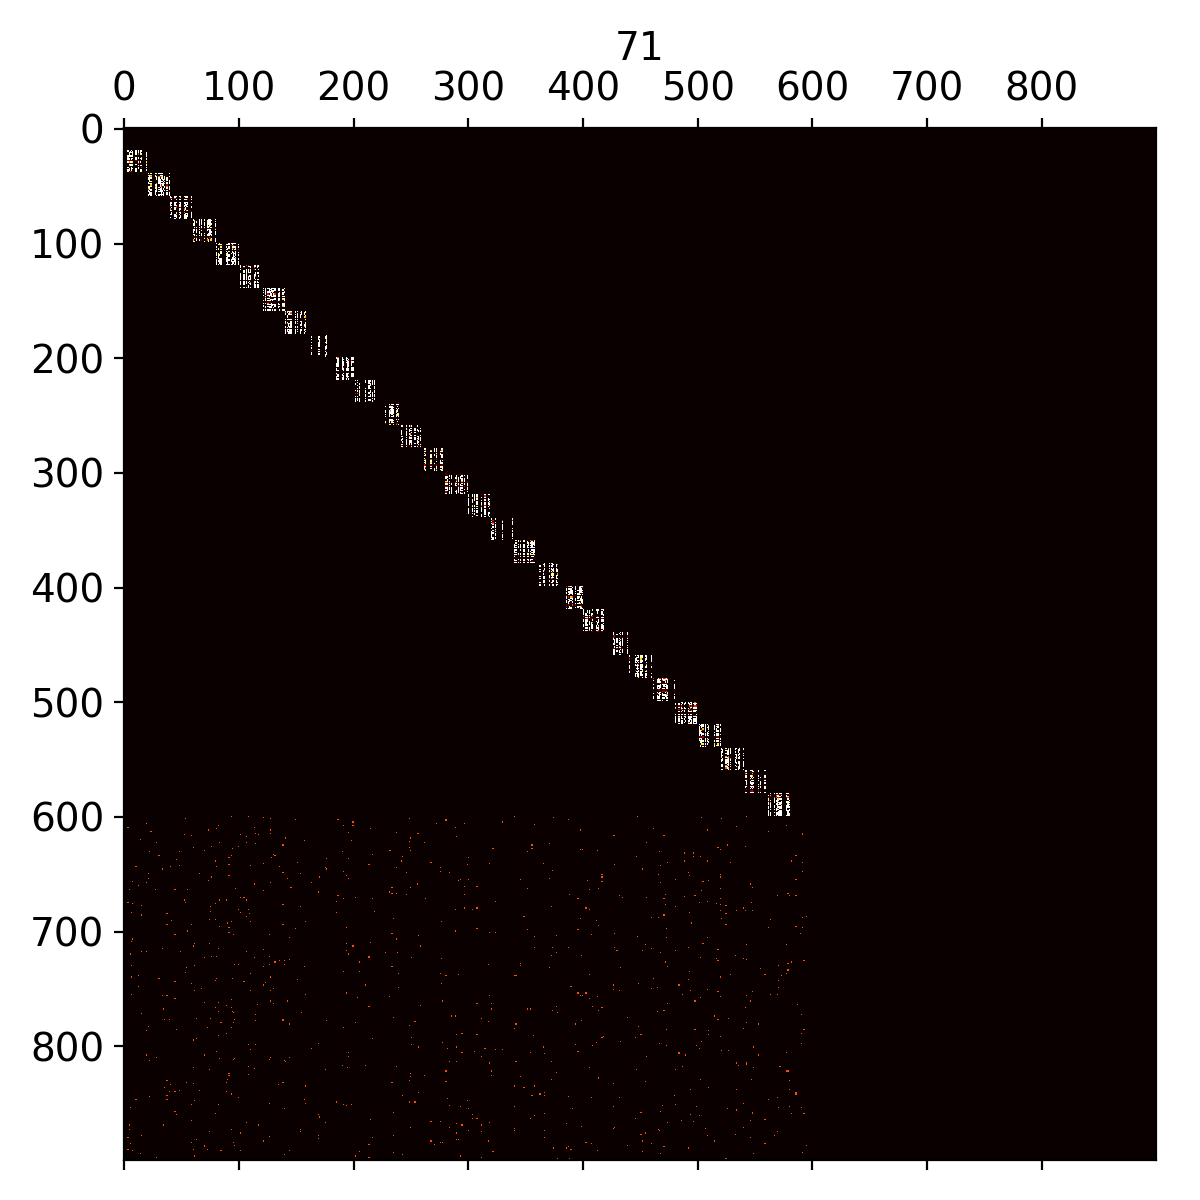

In [7]:
w_r_e_initial, w_r_e_final = animate('./robustness/noise_ff_1.7_pf_0.7_pr_0.0_eir_2.5_ier_0.3_dropout_sweep_2021-04-22--11:08--35:7345', 1, 0.26 * 0.004 * 1 / 20,
                                 cmap='hot', kind='w_r_e')

<IPython.core.display.Javascript object>


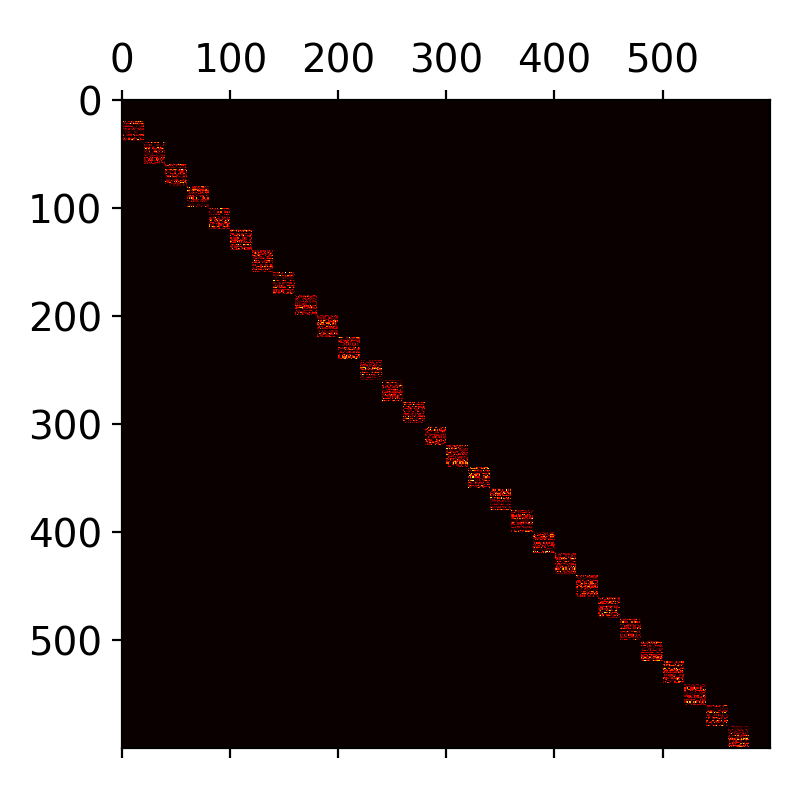

<IPython.core.display.Javascript object>


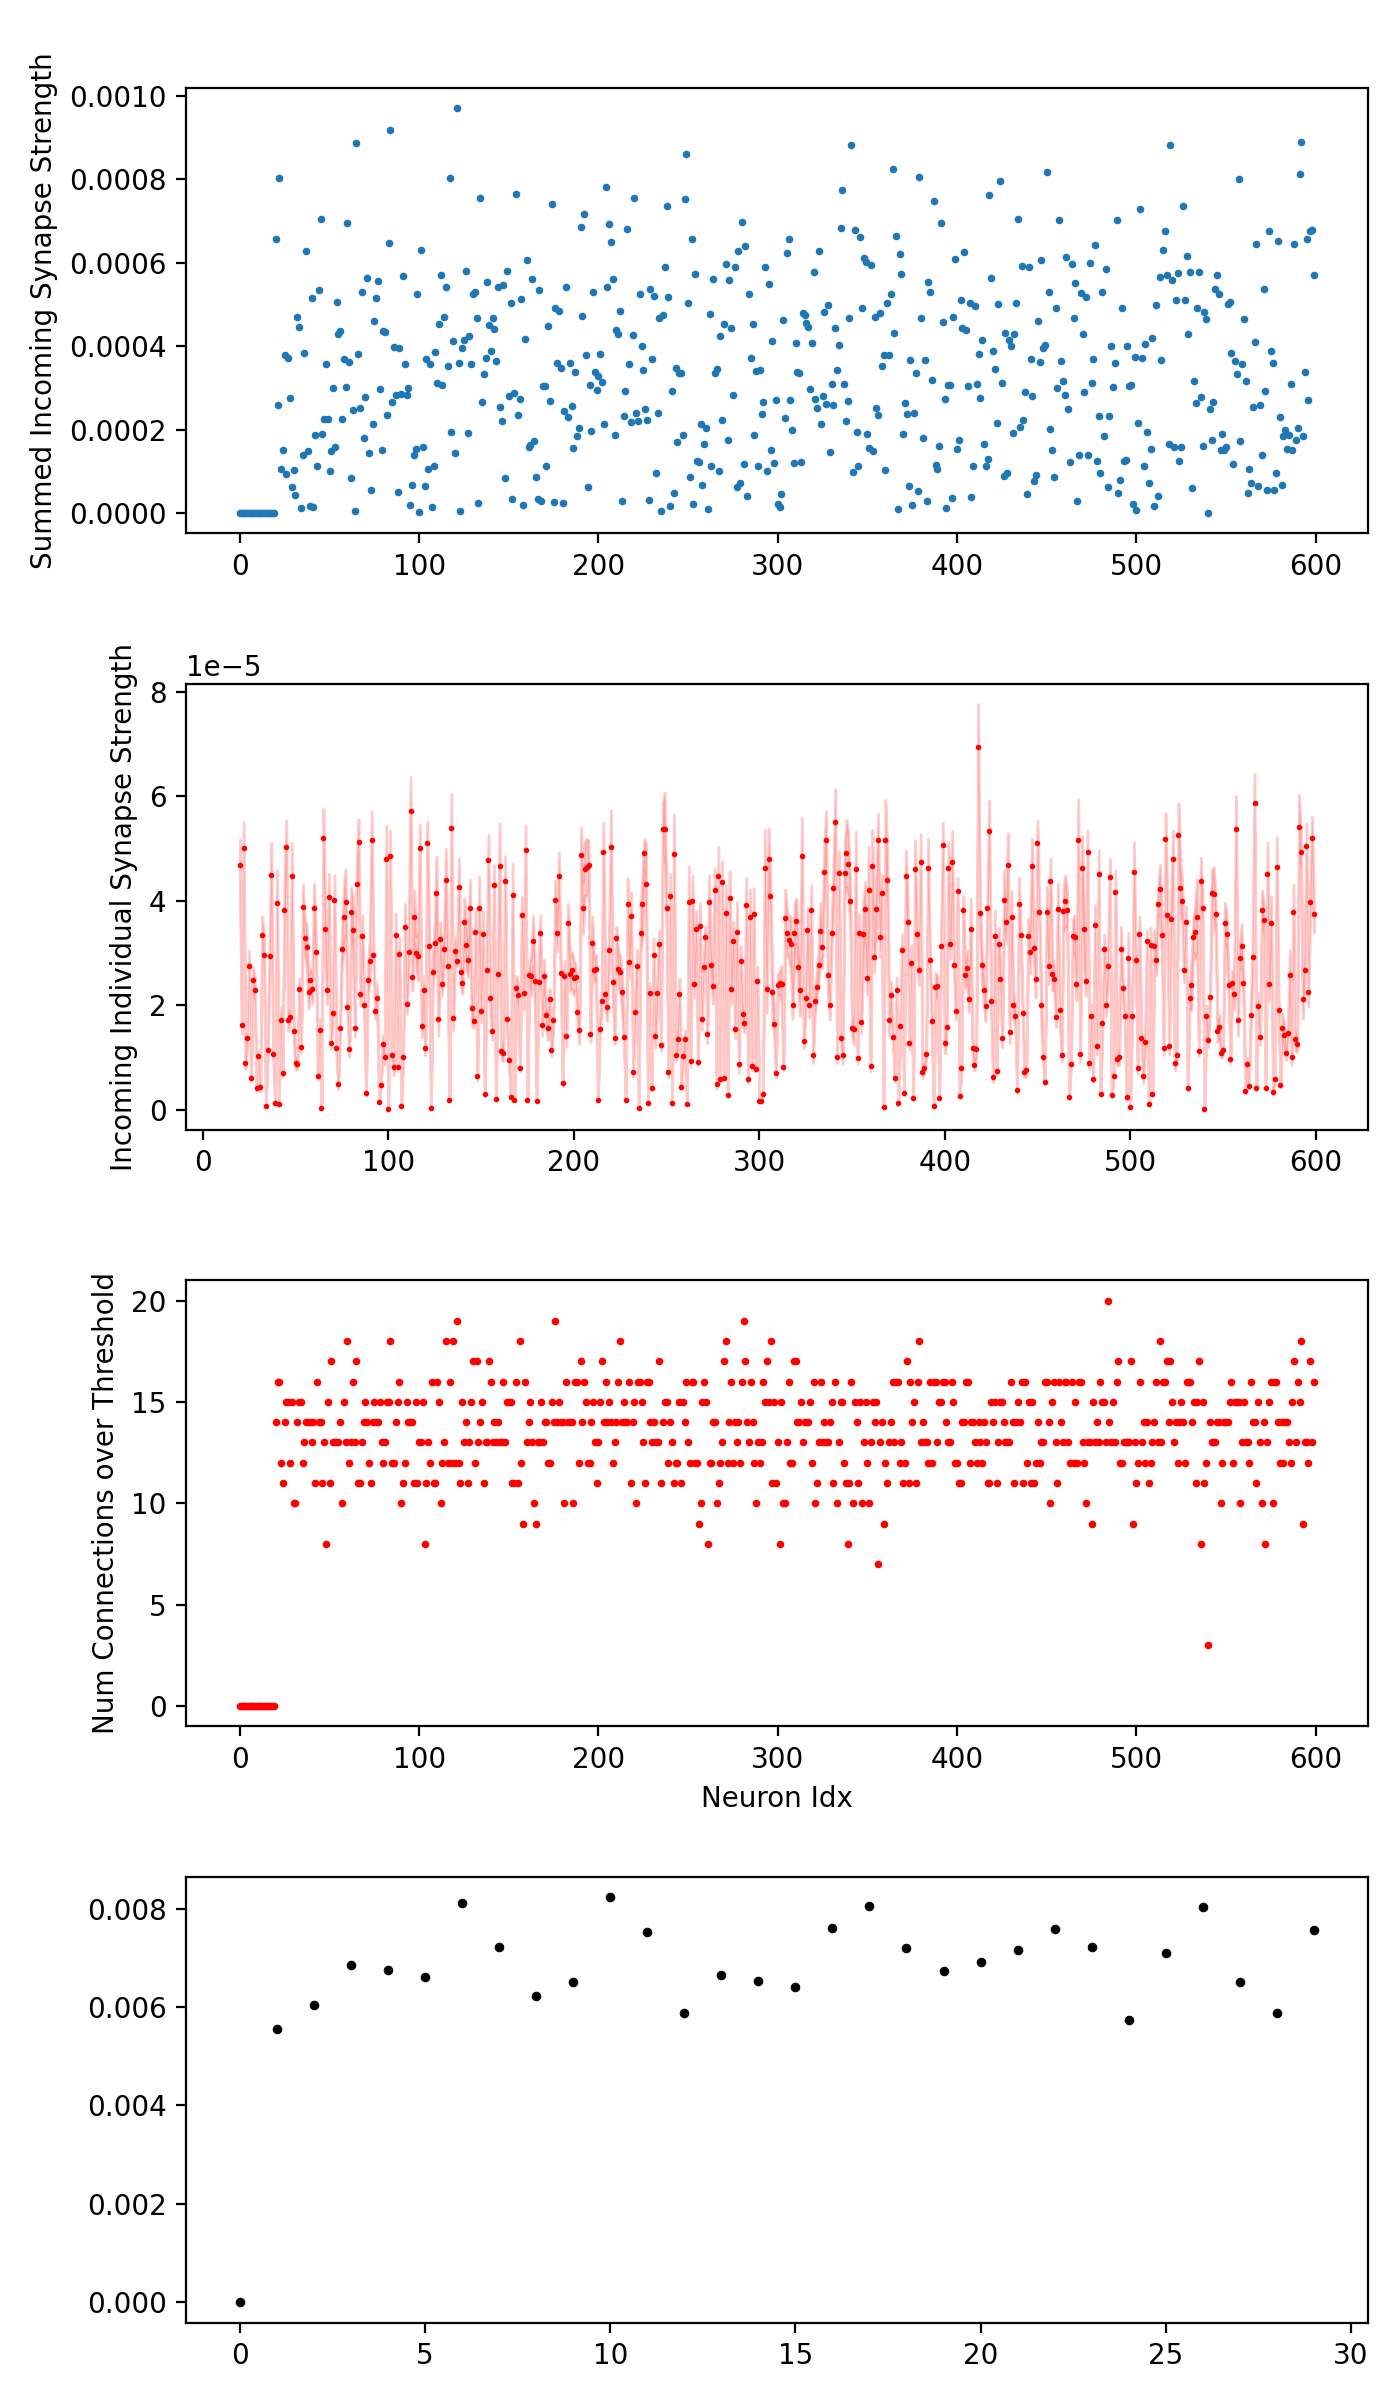

average summed incoming weight per cell: 0.00033408814069749106 +/- 0.00021655597114607624
average incoming connections per cell: 13.131666666666666 +/- 3.216260337030502


In [10]:
plot_w_r(w_r_e_initial, row_max=600, col_max=600)

<IPython.core.display.Javascript object>


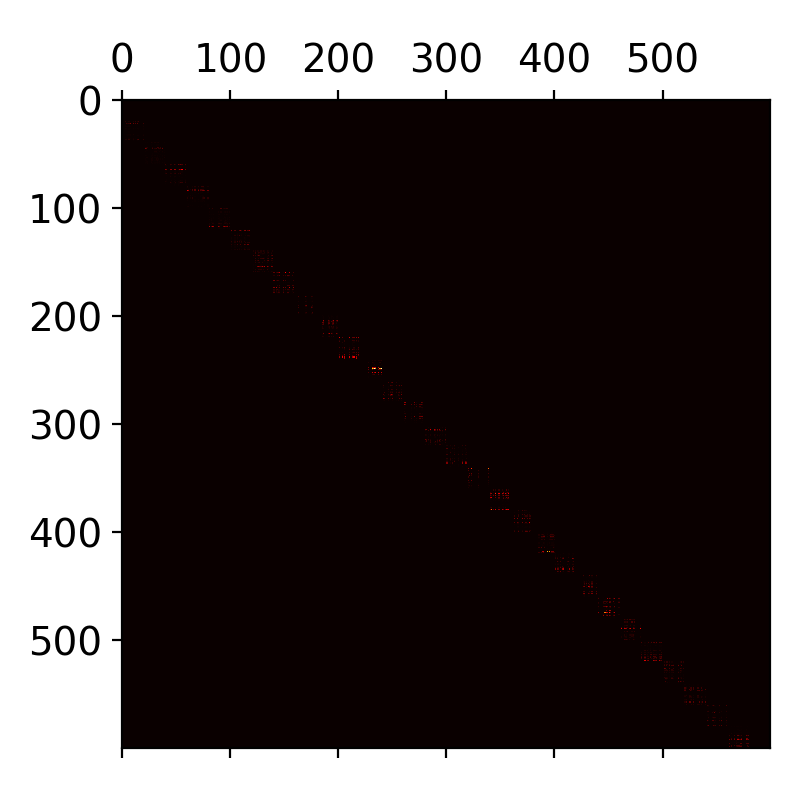

<IPython.core.display.Javascript object>


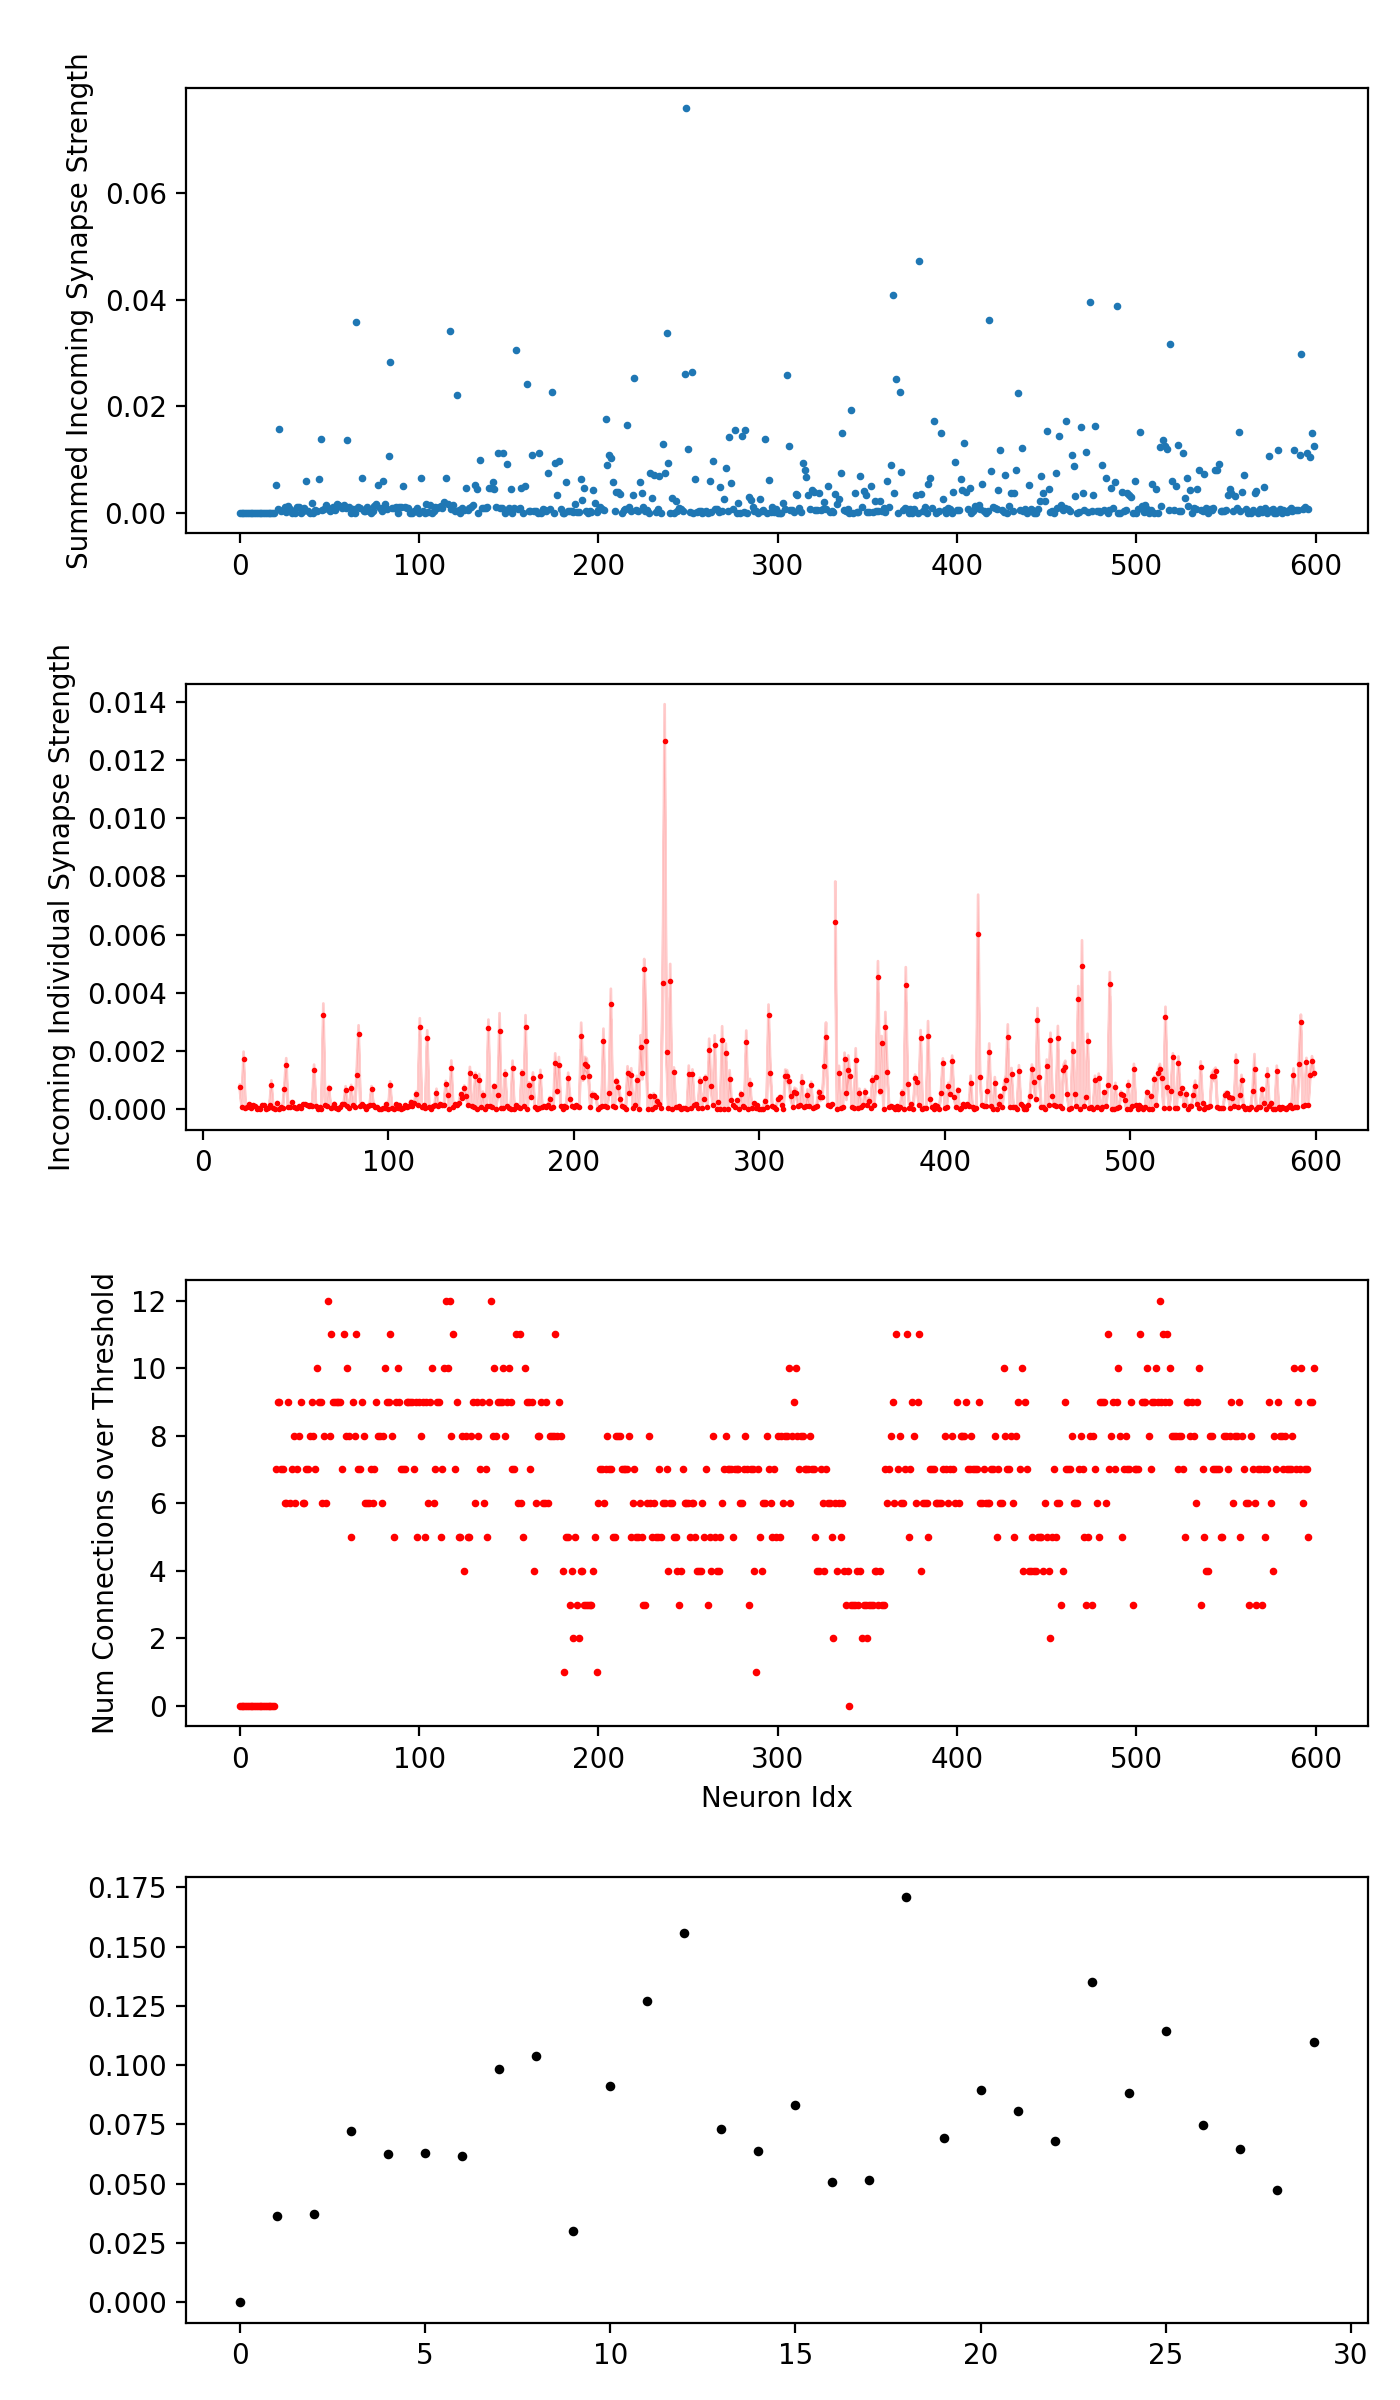

average summed incoming weight per cell: 0.0039581328717634475 +/- 0.007273246079187792
average incoming connections per cell: 6.568333333333333 +/- 2.382994731192012


In [11]:
plot_w_r(w_r_e_final, row_max=600, col_max=600)

$$ \Delta w_{ij} = \alpha w_{ij} (f_{0} - f_j) $$

$$ \Delta w_{ij} = \alpha w_{ij} (N_E f_{0} - \sum_{j} f_j)$$

<IPython.core.display.Javascript object>


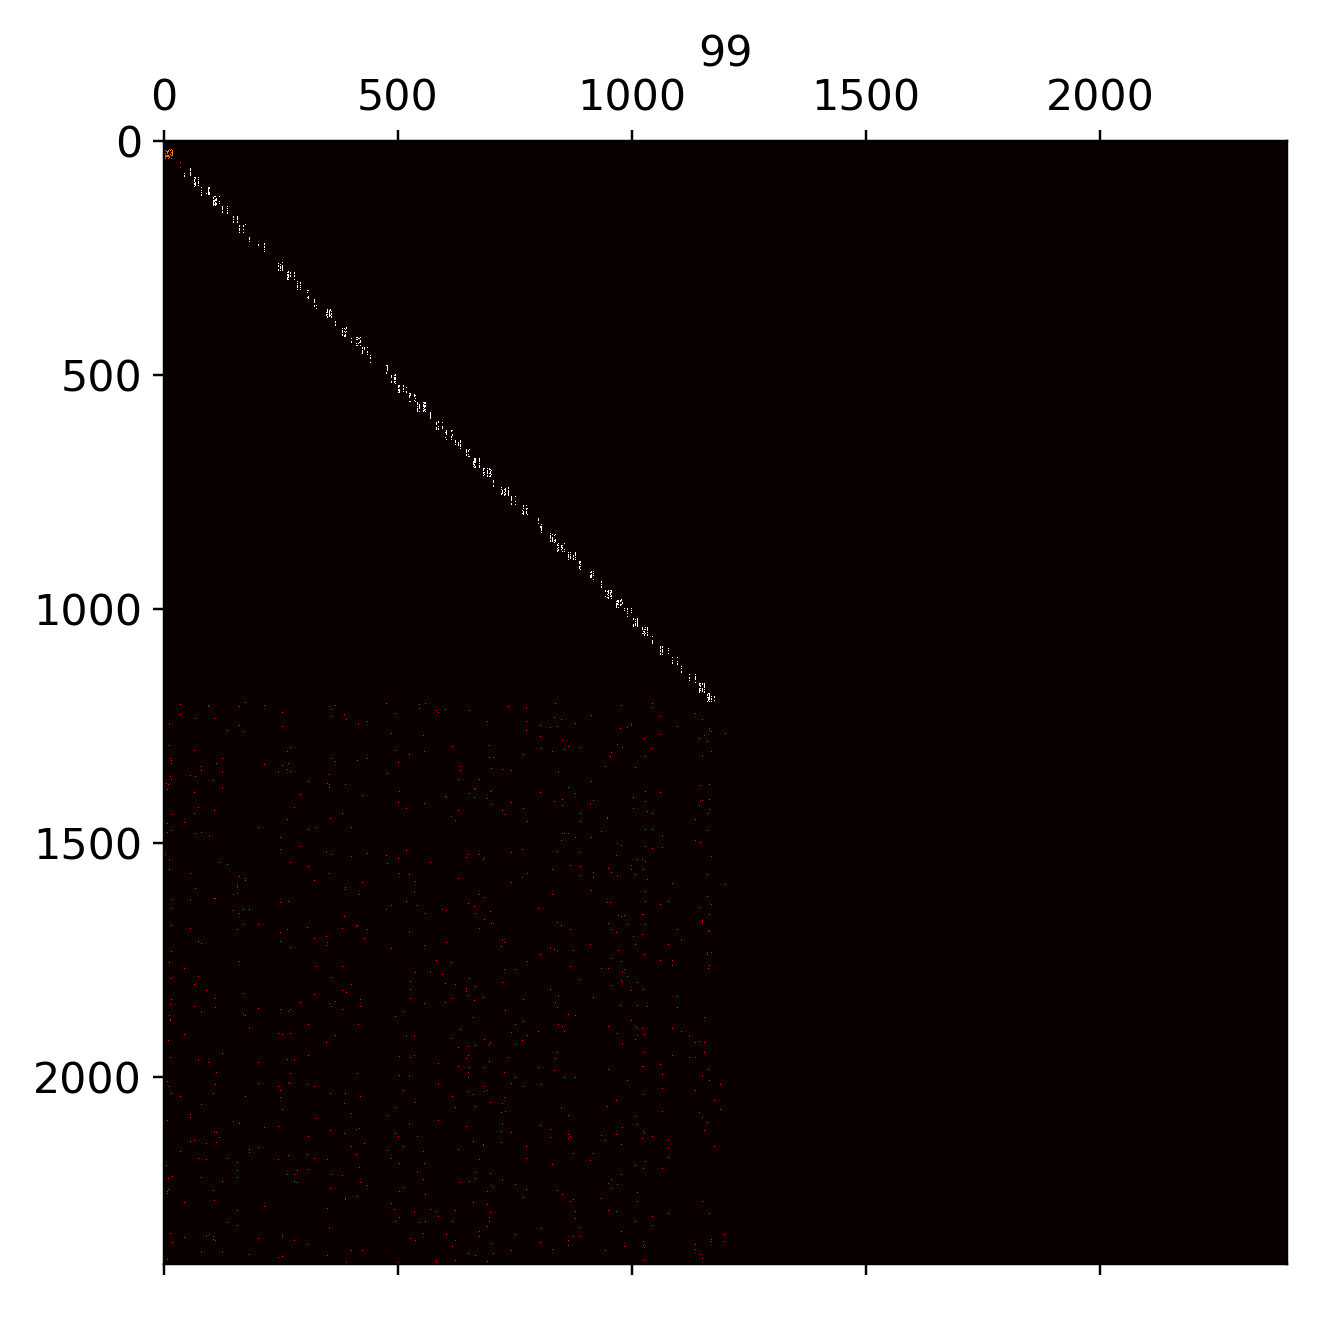

In [23]:
w_r_e_initial, w_r_e_final = animate('./robustness/noise_ff_0.4_pf_0.5_pr_0.0_eir_2.0_ier_0.3_dropout_sweep_2021-03-30--23:51--08:6420', 10, 0.26 * 0.004 * 1 / 20,
                                 cmap='hot', kind='w_r_e')

<IPython.core.display.Javascript object>


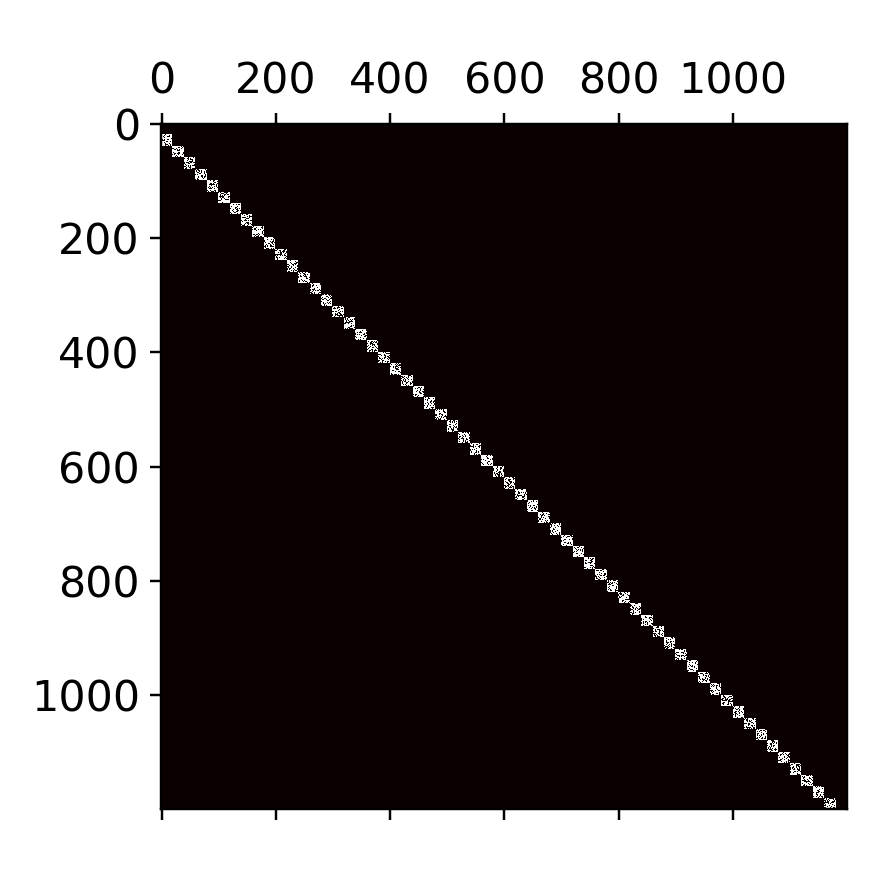

<IPython.core.display.Javascript object>


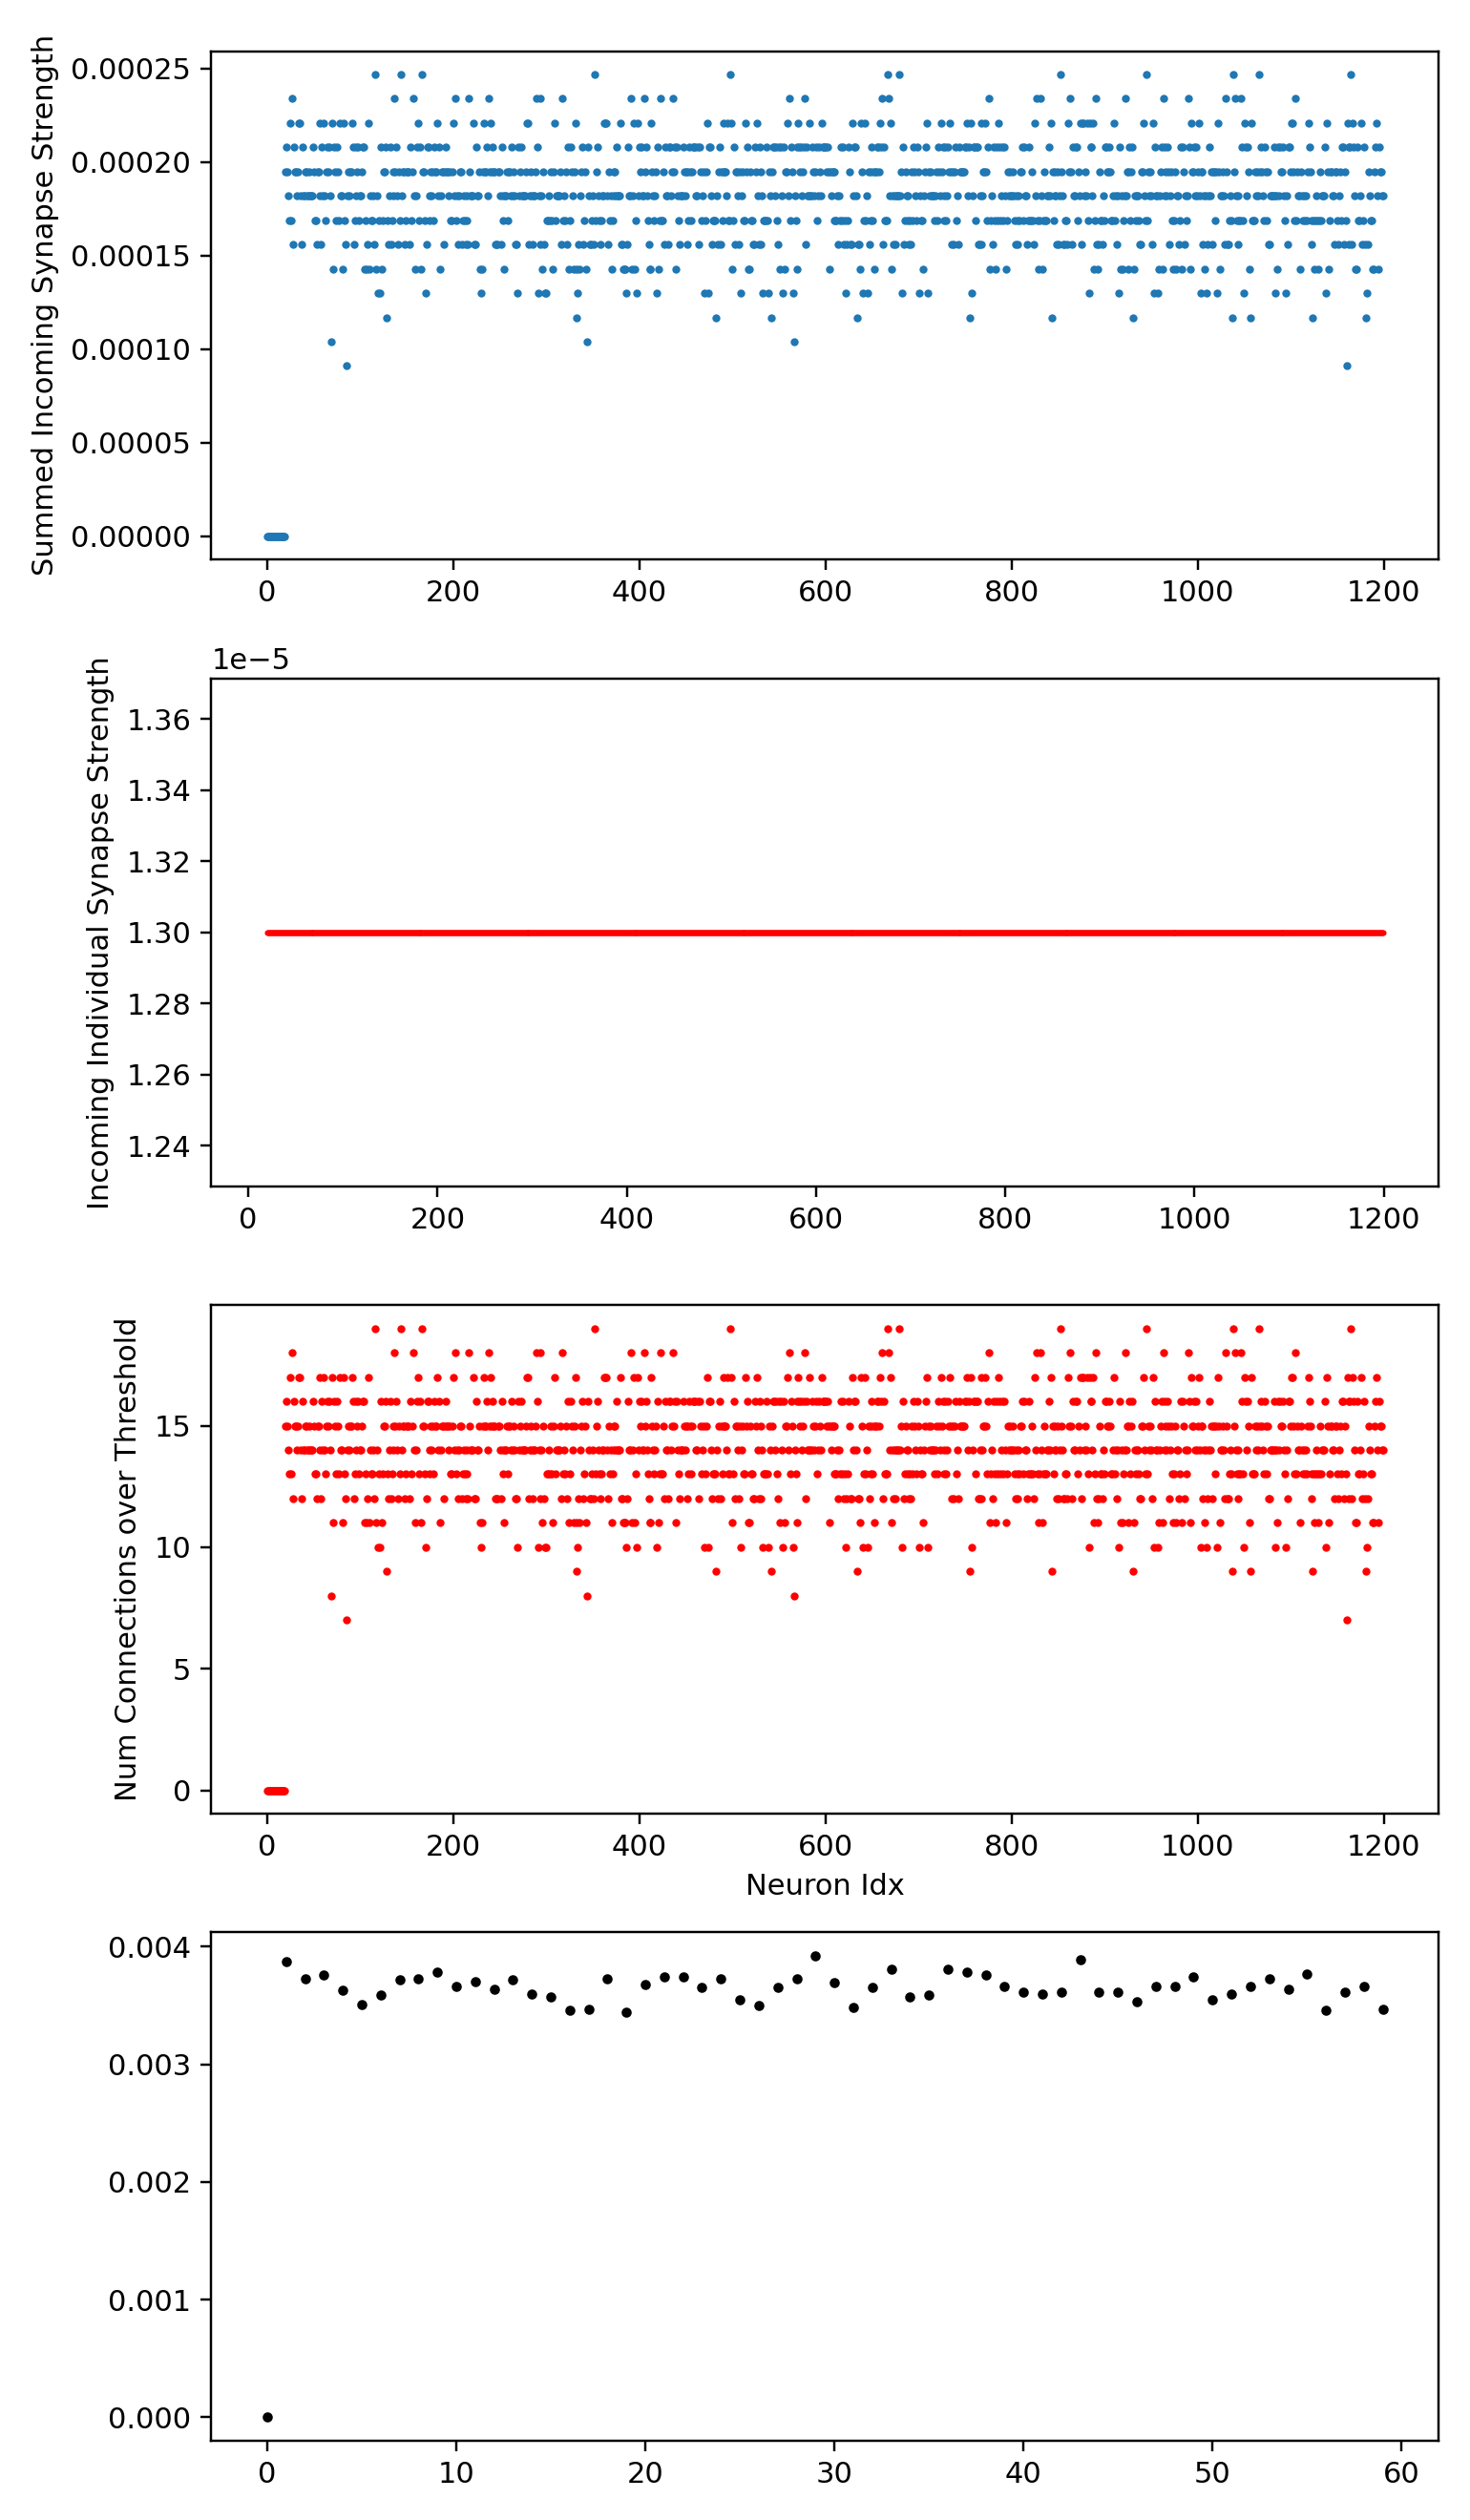

average summed incoming weight per cell: 0.00017981166666666663 +/- 3.4854380842139314e-05
average incoming connections per cell: 13.831666666666667 +/- 2.681106218626102


In [41]:
plot_w_r(w_r_e_initial, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


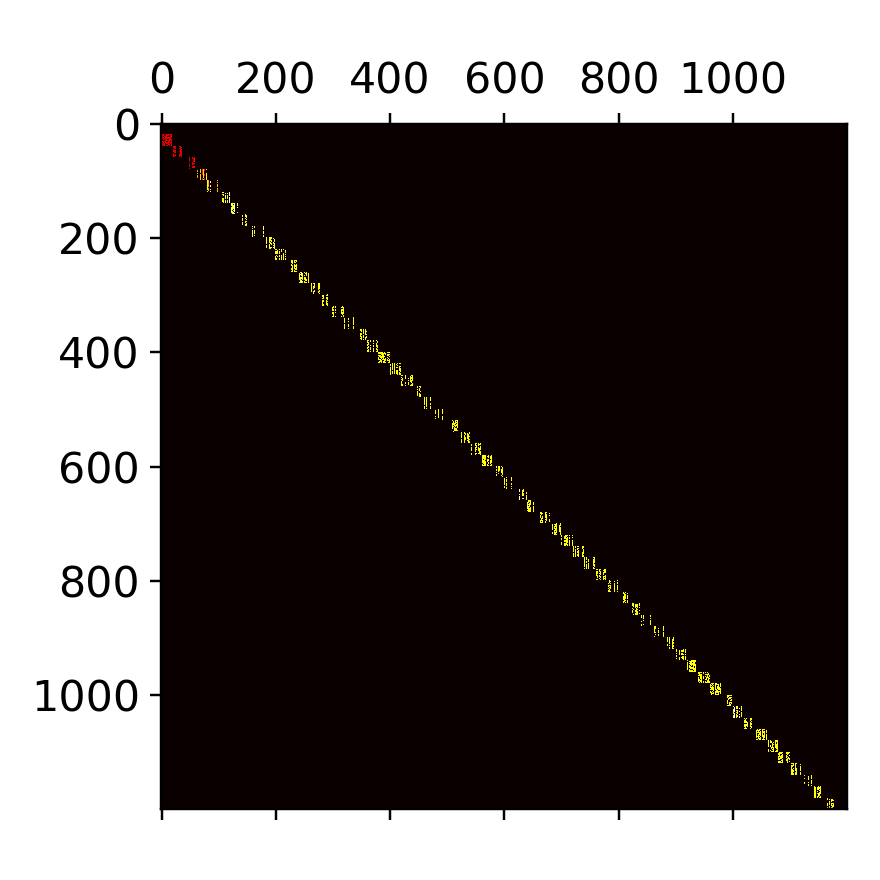

<IPython.core.display.Javascript object>


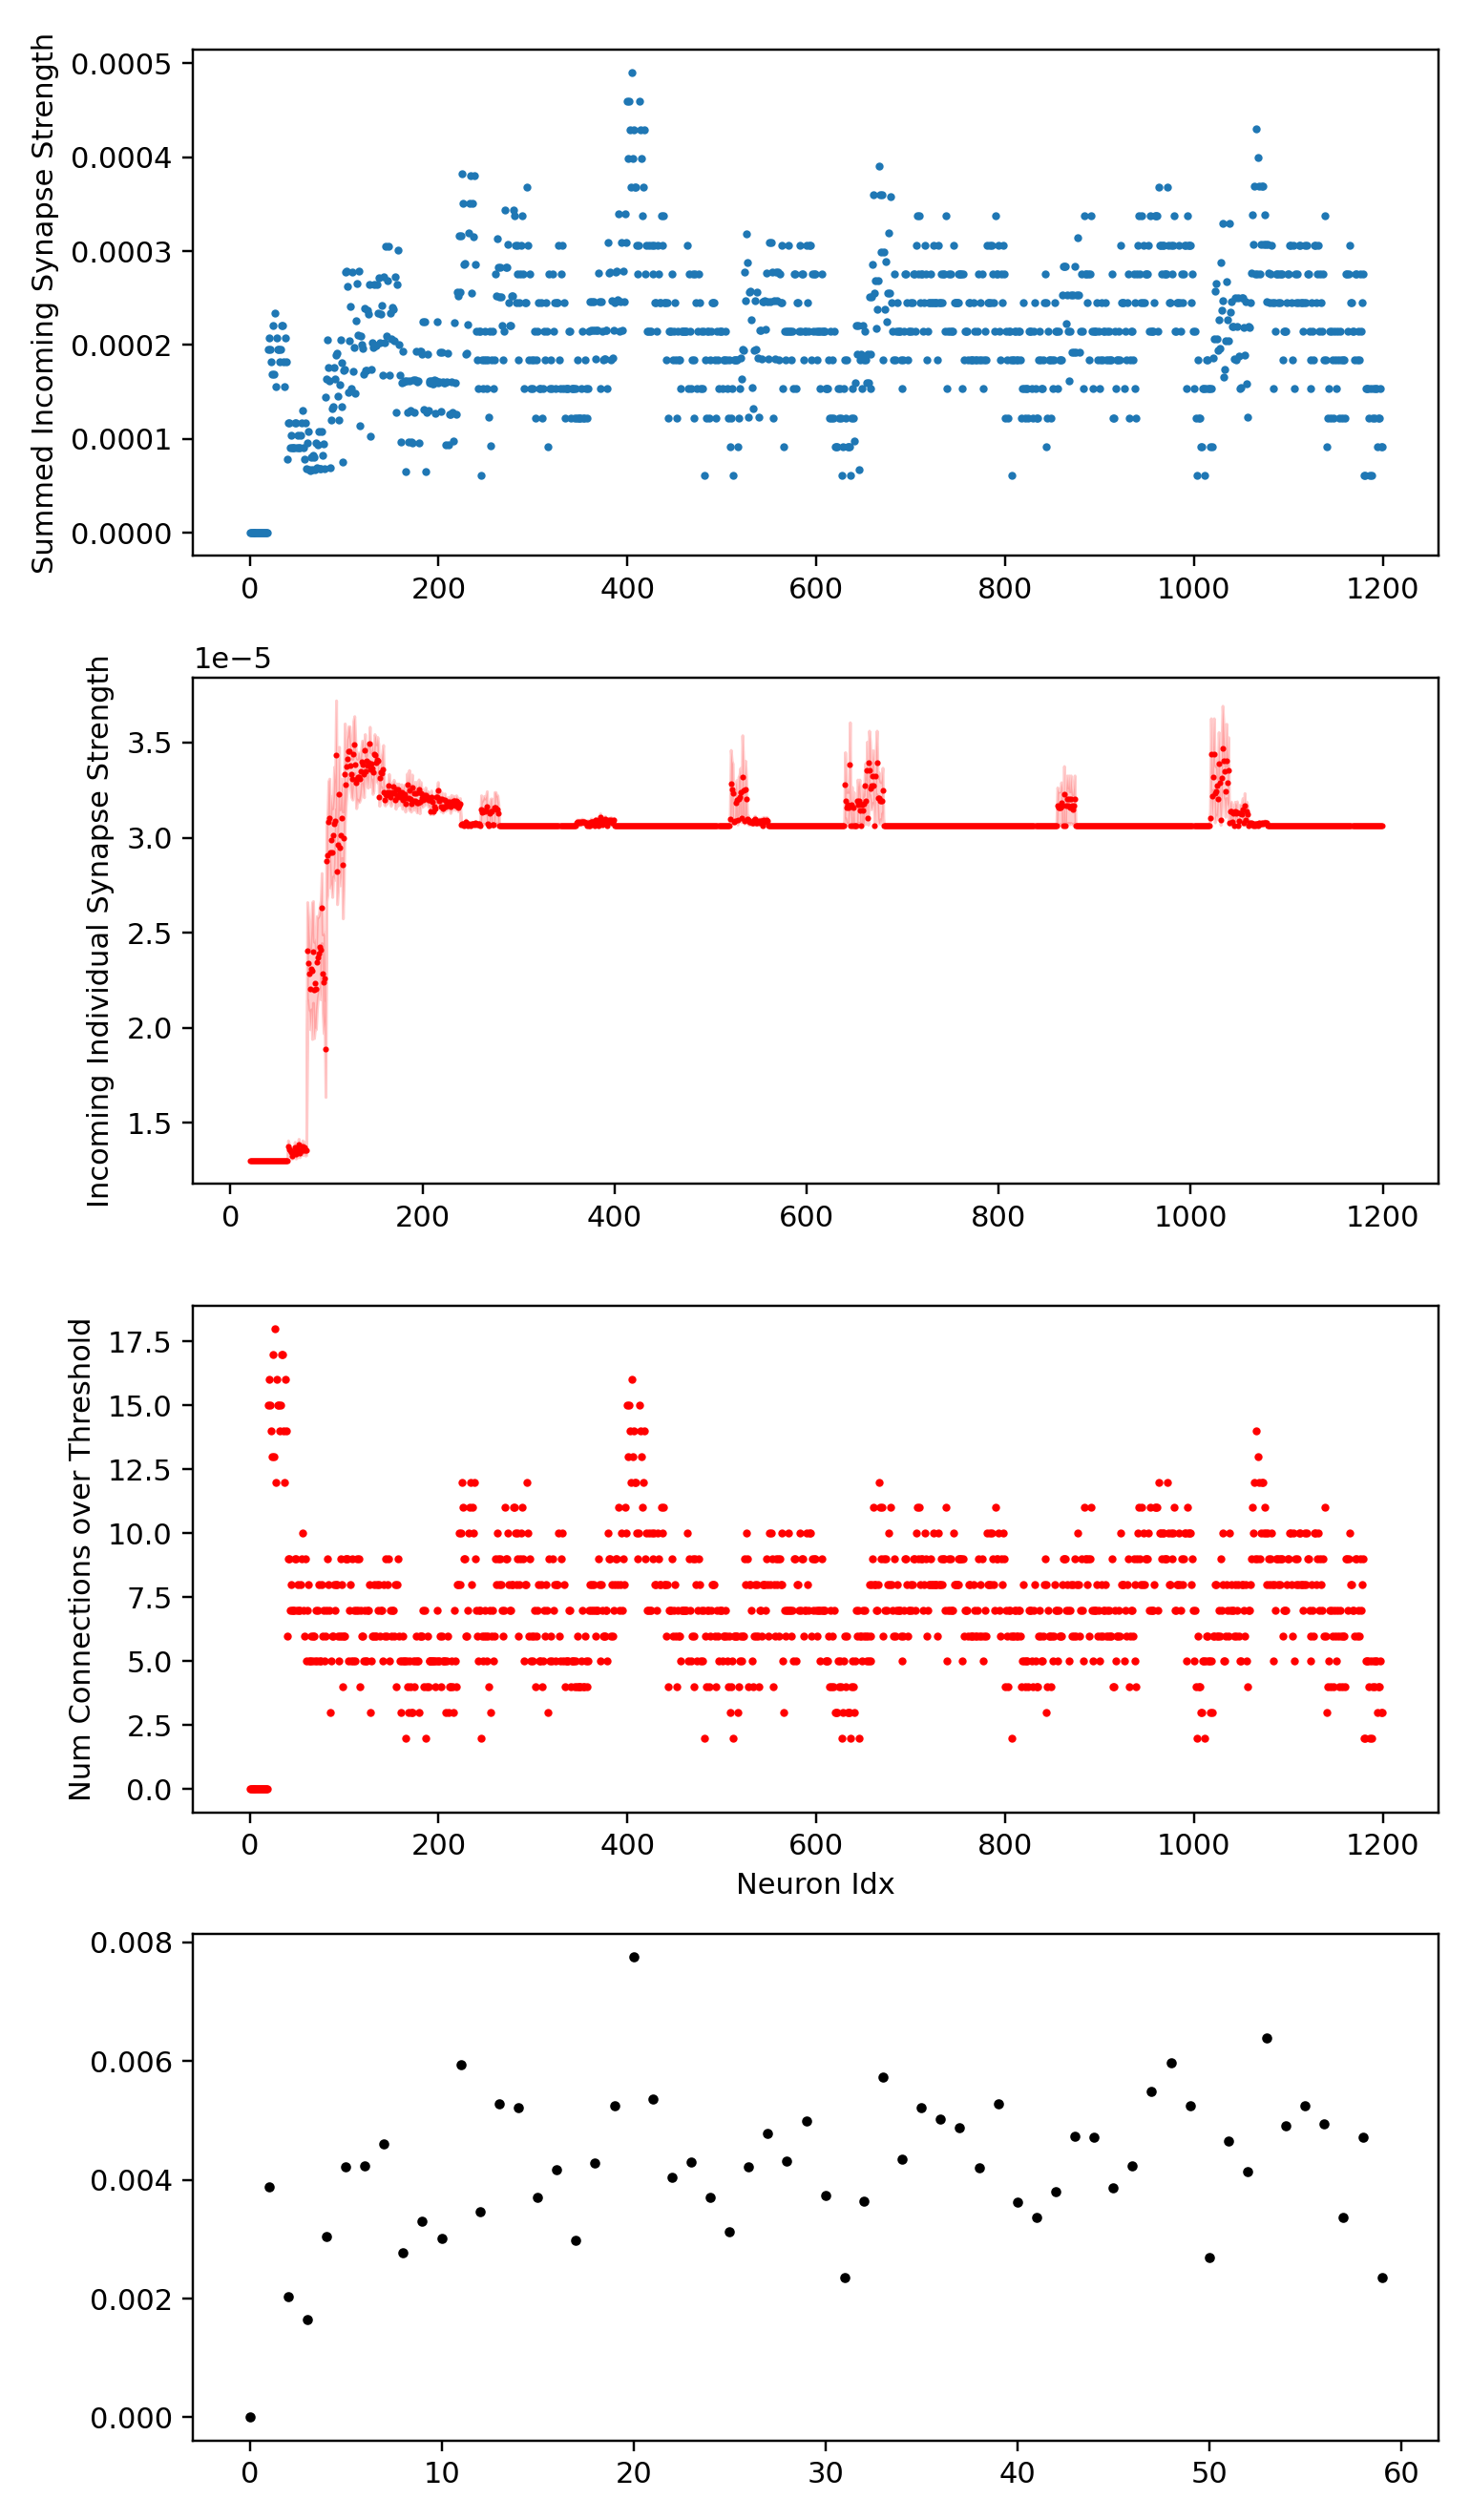

average summed incoming weight per cell: 0.00021042069252933323 +/- 7.480467523089612e-05
average incoming connections per cell: 7.0925 +/- 2.5368504915872885


In [42]:
plot_w_r(w_r_e_final, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


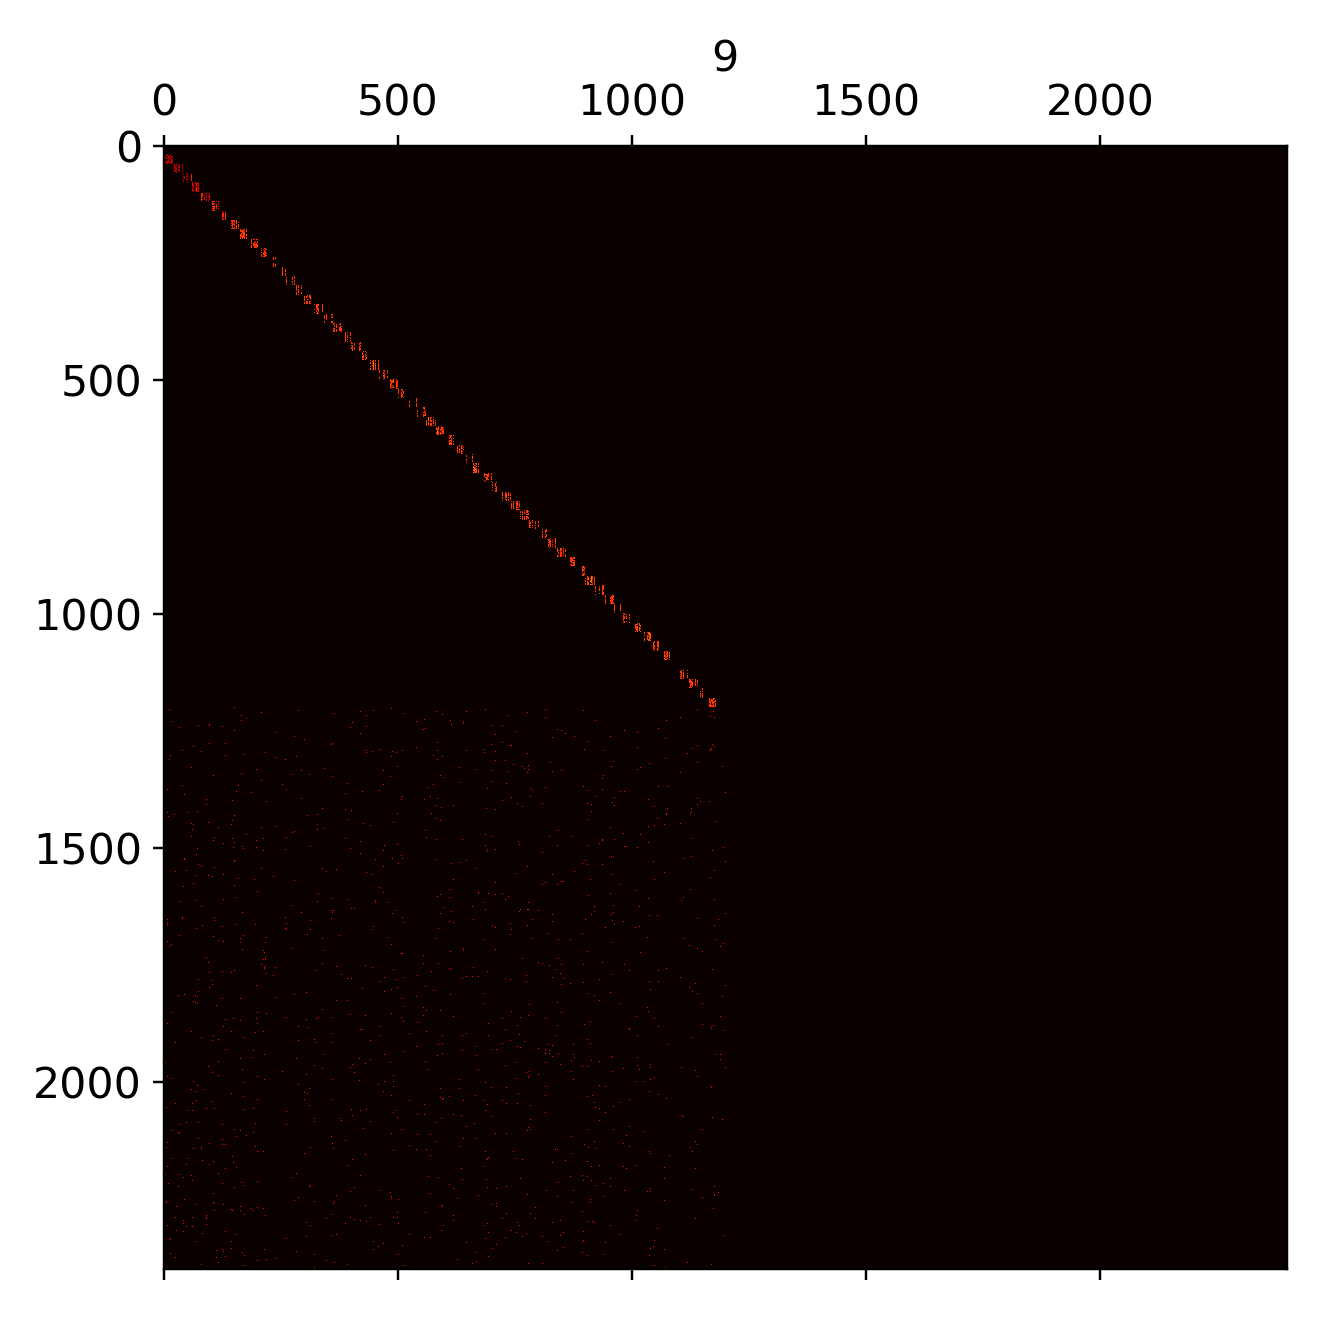

In [24]:
w_r_e_initial, w_r_e_final = animate('./robustness/noise_ff_0.2_pf_0.7_pr_0.0_eir_2.0_ier_0.3_dropout_sweep_2021-03-31--00:22--48:1469', 10, 0.26 * 0.004 * 1 / 20,
                                 cmap='hot', kind='w_r_e', cut=10)

<IPython.core.display.Javascript object>


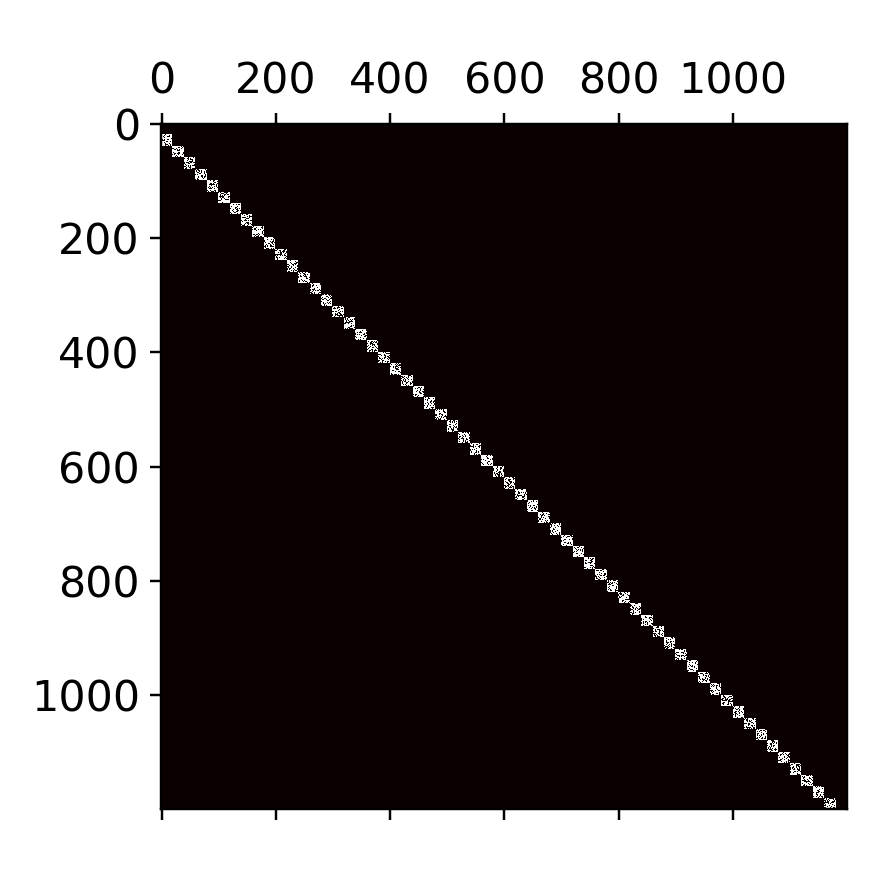

<IPython.core.display.Javascript object>


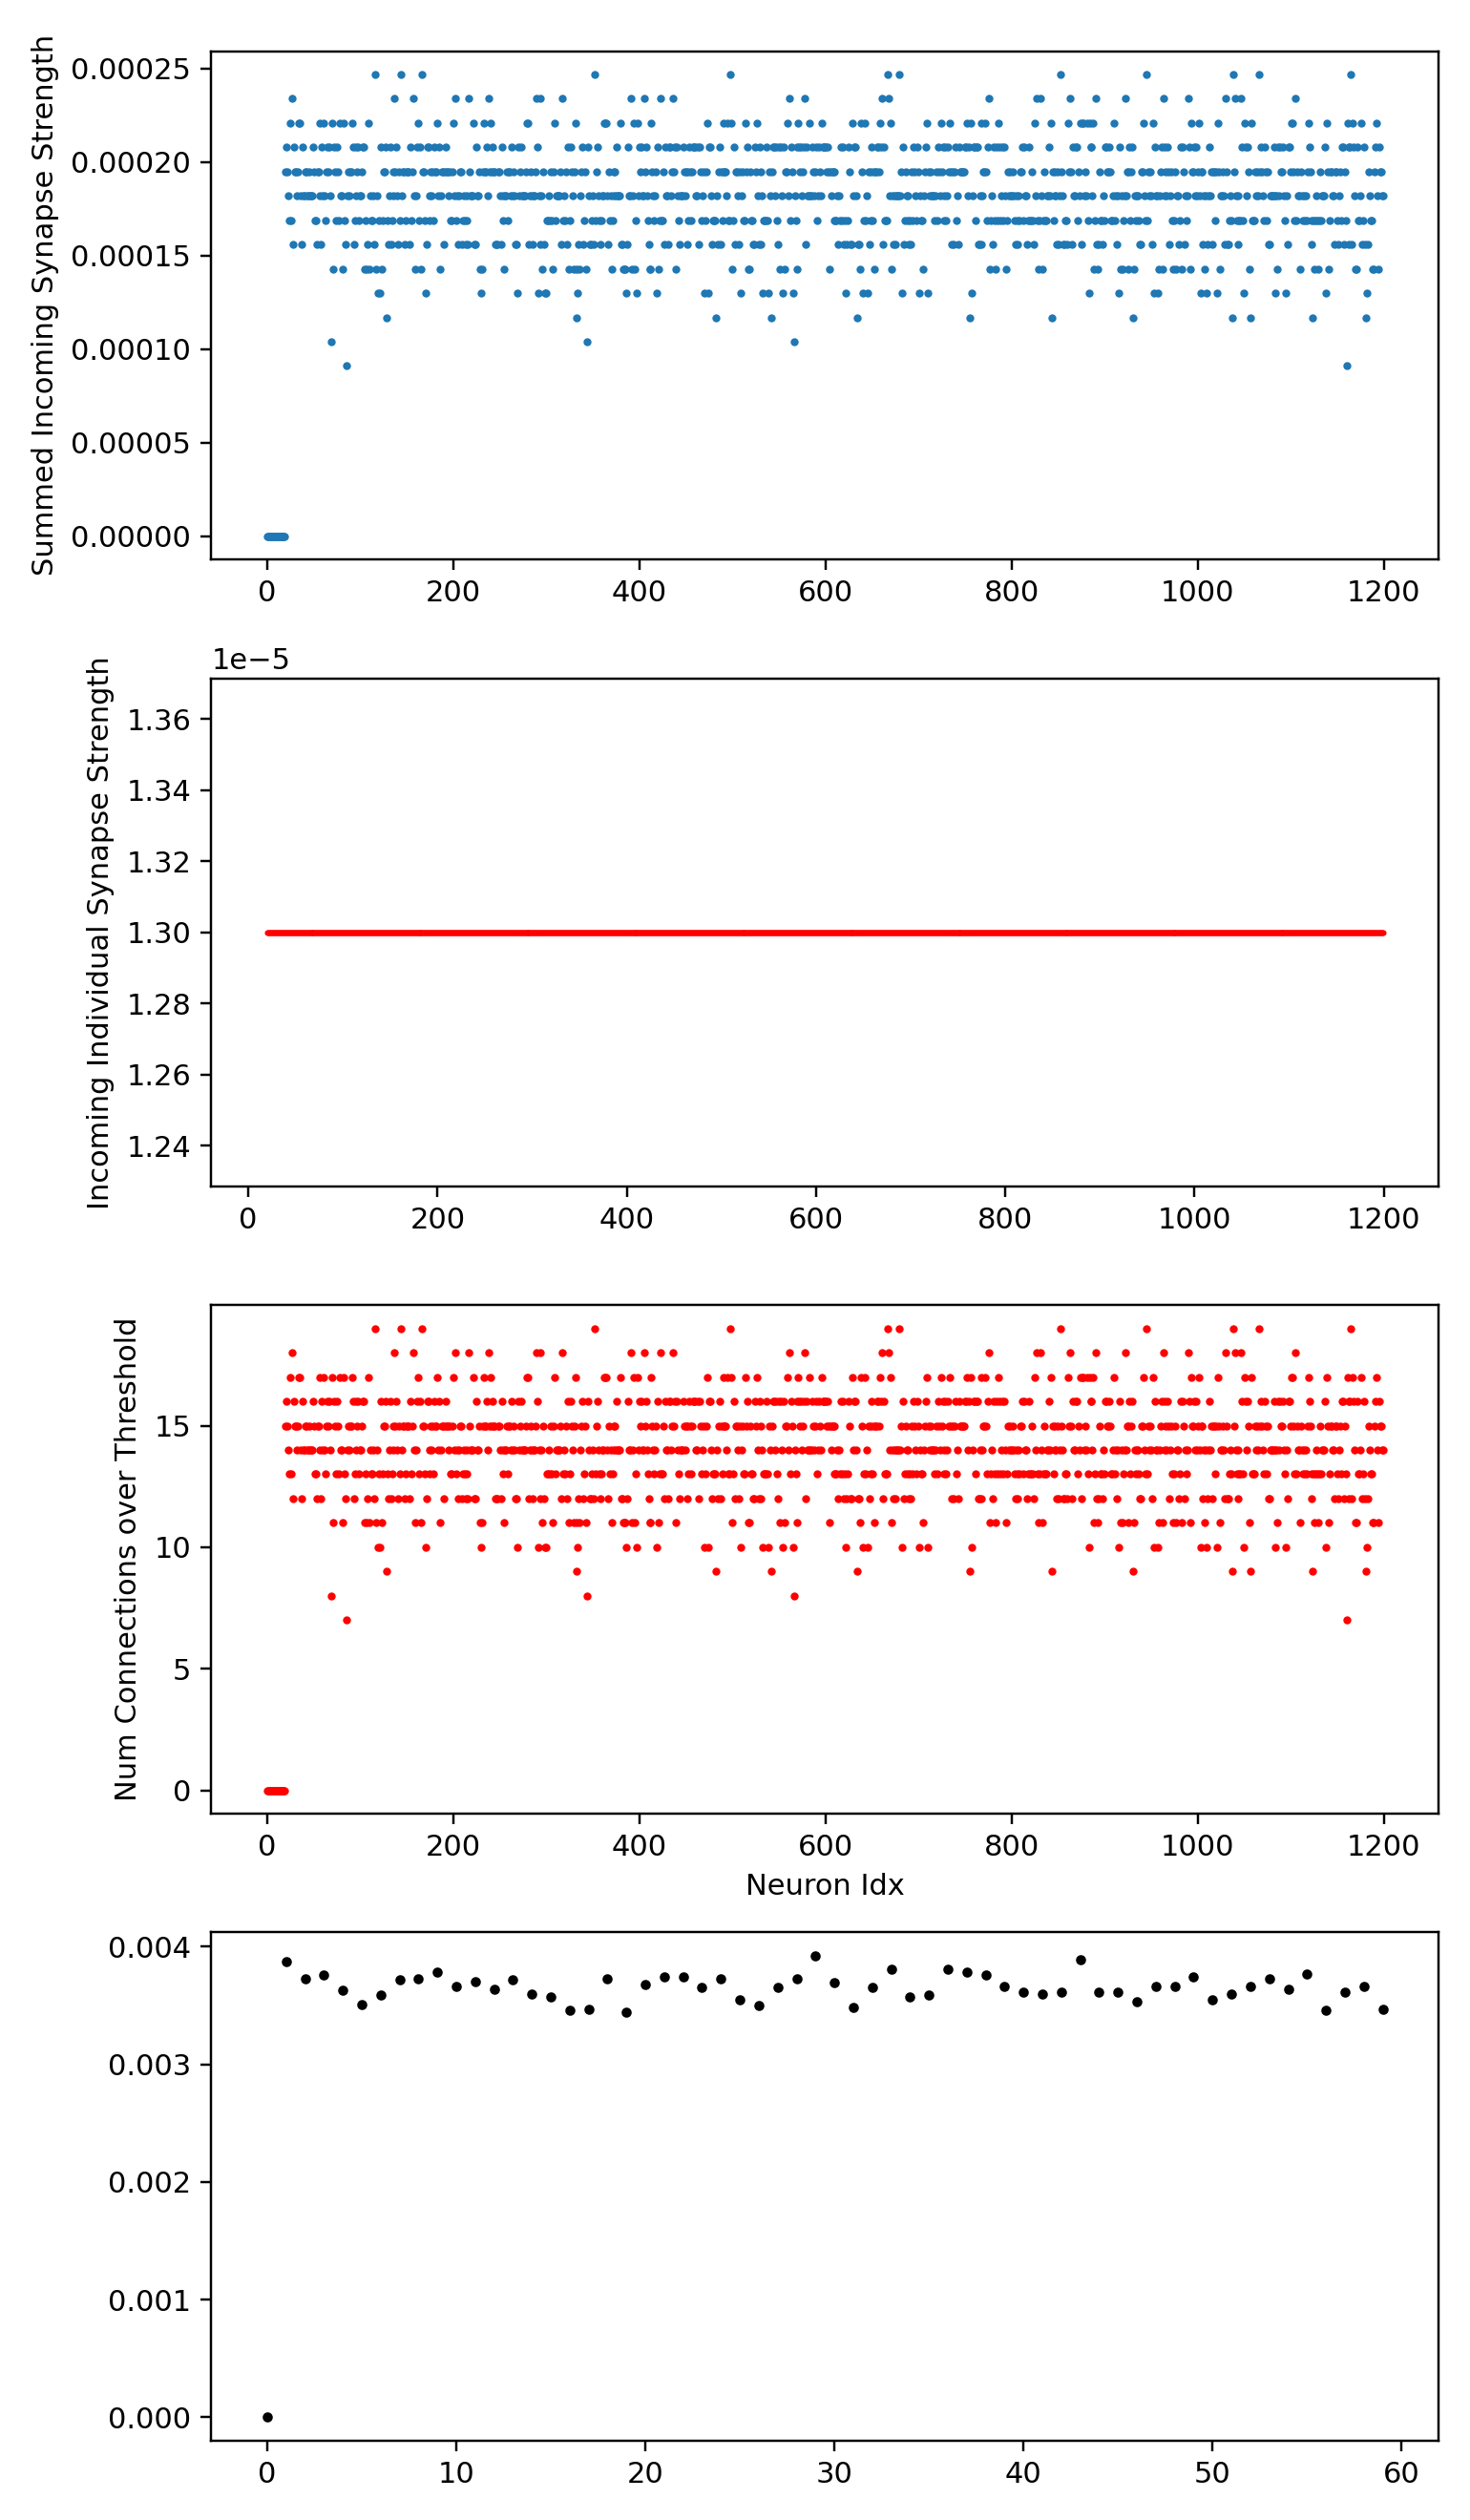

average summed incoming weight per cell: 0.00017981166666666663 +/- 3.4854380842139314e-05
average incoming connections per cell: 13.831666666666667 +/- 2.681106218626102


In [43]:
plot_w_r(w_r_e_initial, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


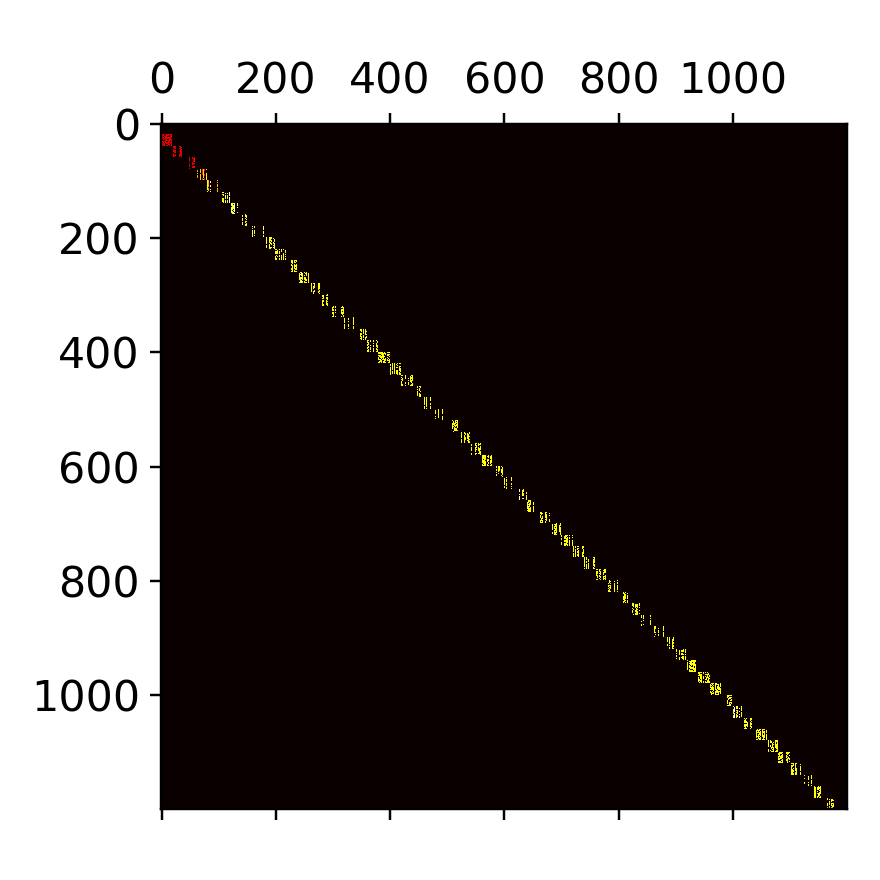

<IPython.core.display.Javascript object>


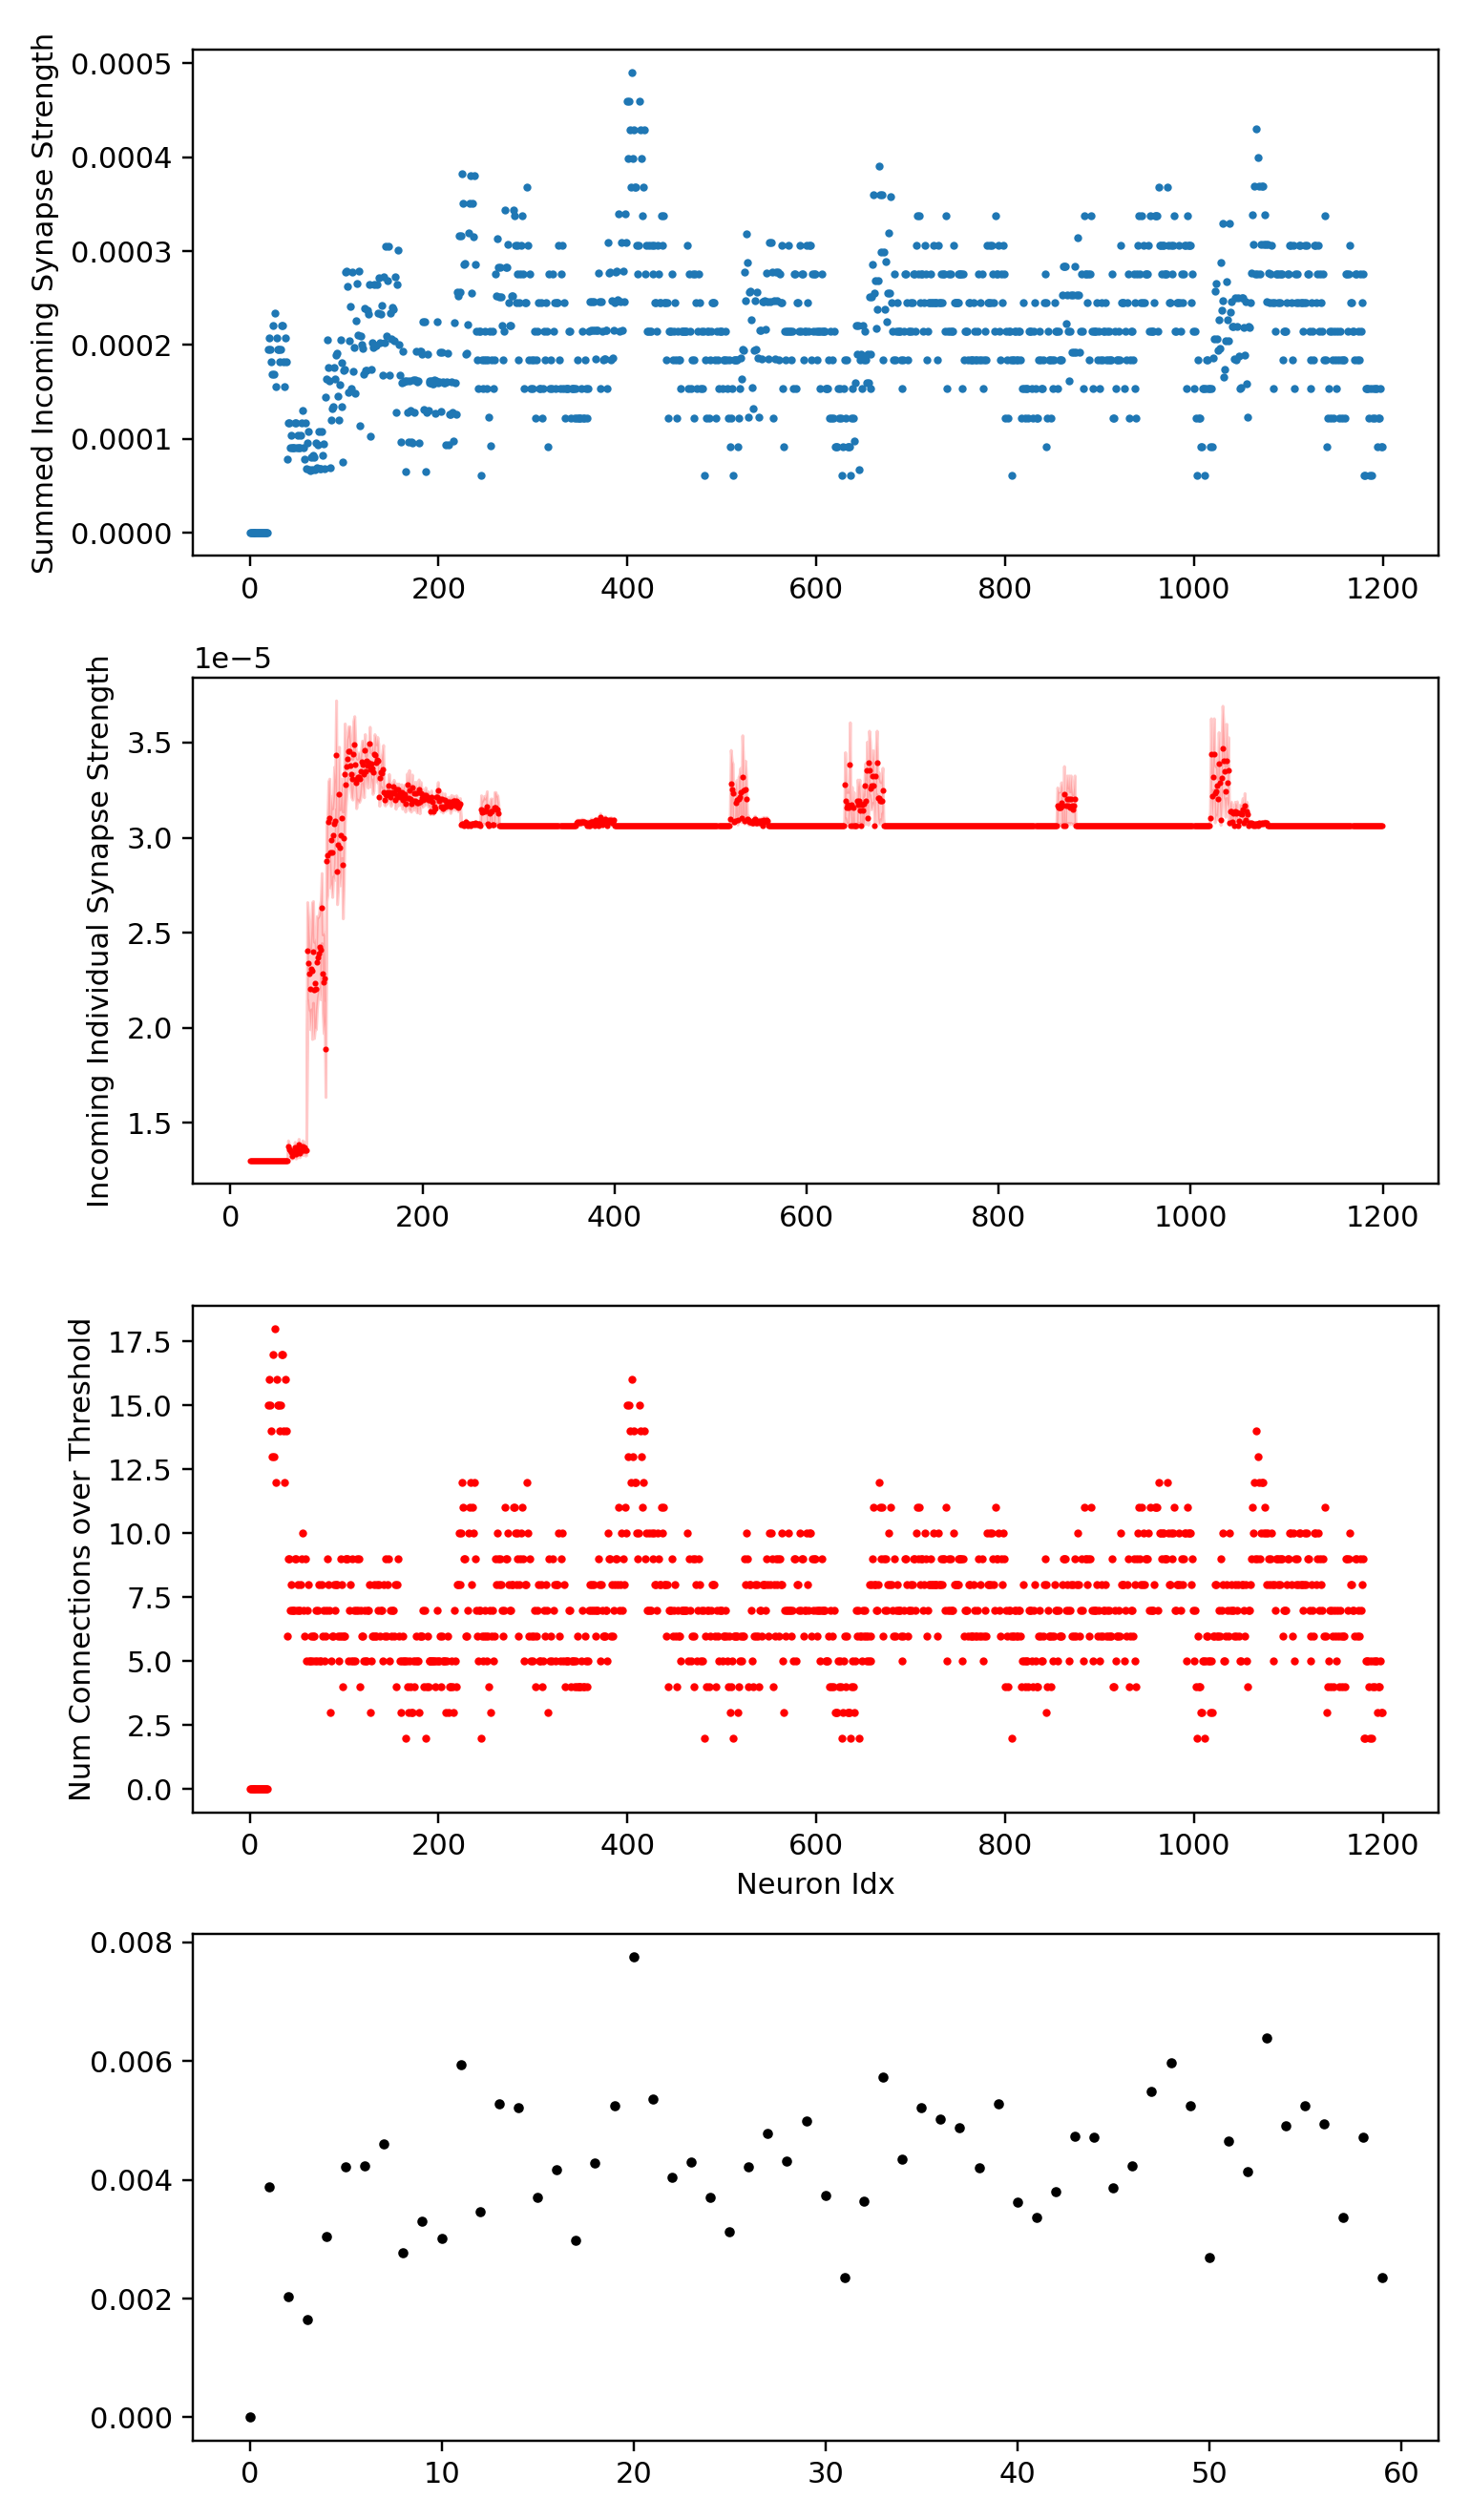

average summed incoming weight per cell: 0.00021042069252933323 +/- 7.480467523089612e-05
average incoming connections per cell: 7.0925 +/- 2.5368504915872885


In [44]:
plot_w_r(w_r_e_final, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


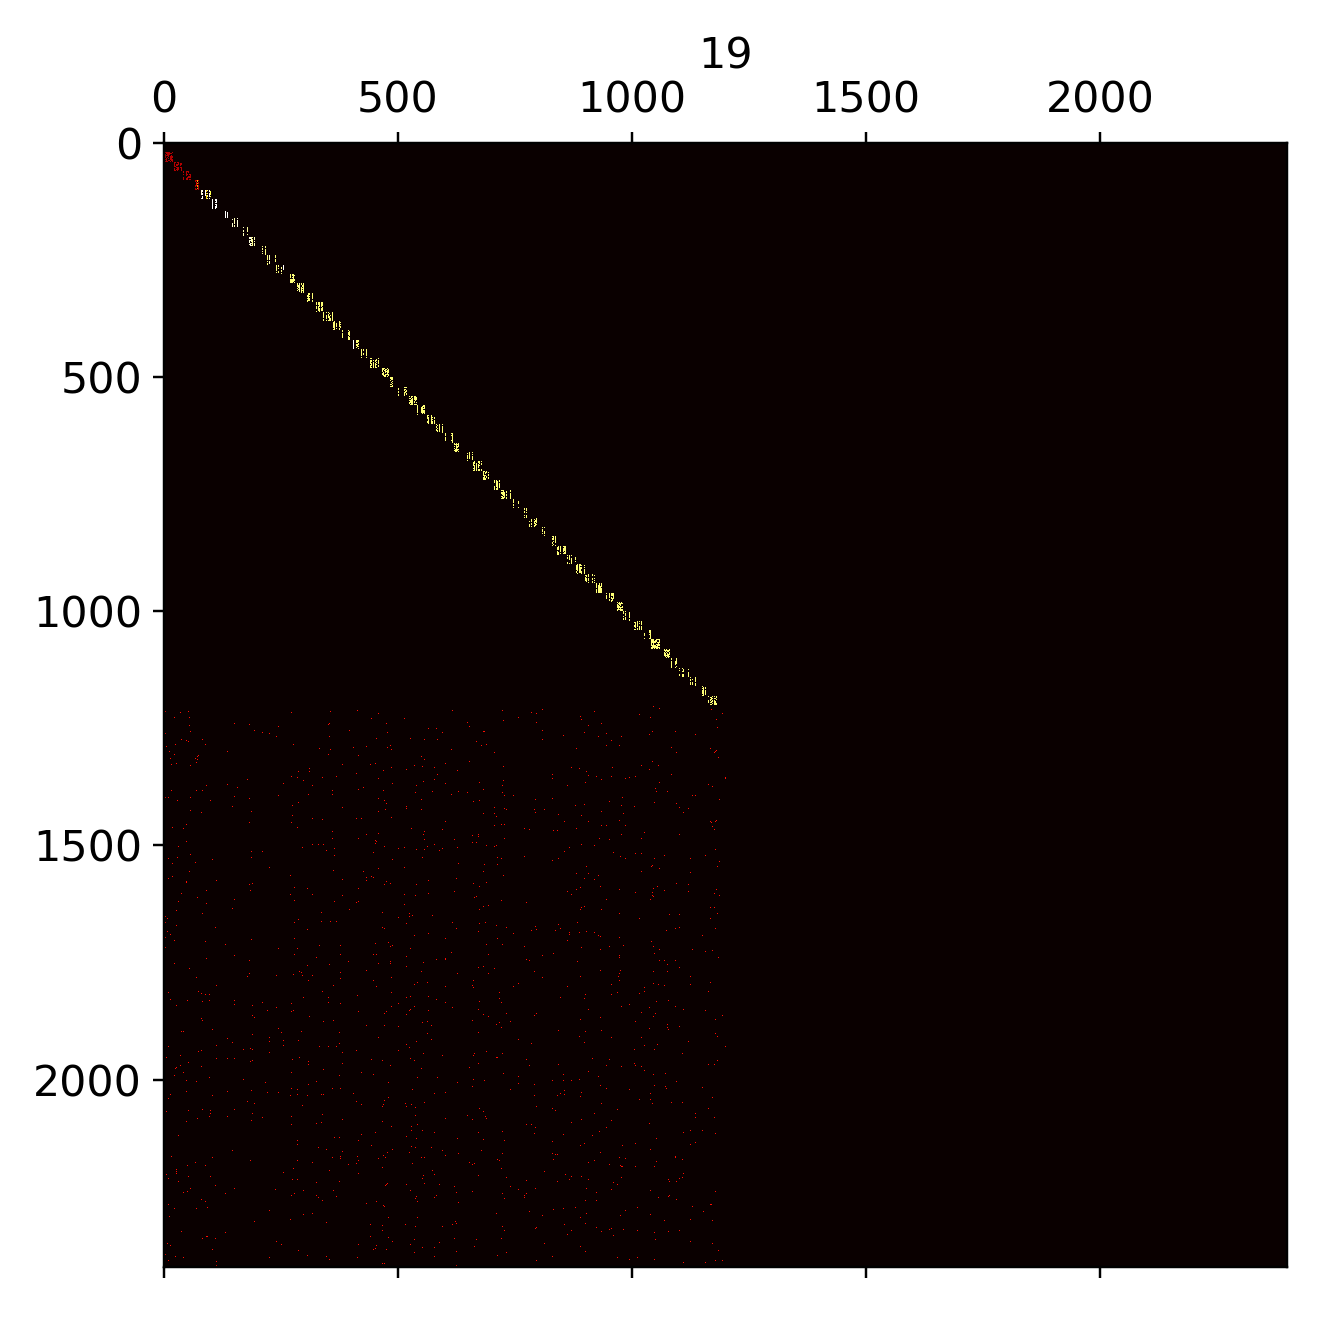

In [31]:
w_r_e_initial, w_r_e_final = animate('./robustness/noise_ff_0.2_pf_0.7_pr_0.0_eir_2.0_ier_0.3_dropout_sweep_2021-03-31--00:27--28:3259', 10, 0.26 * 0.004 * 1 / 20,
                                 cmap='hot', kind='w_r_e', cut=20)

<IPython.core.display.Javascript object>


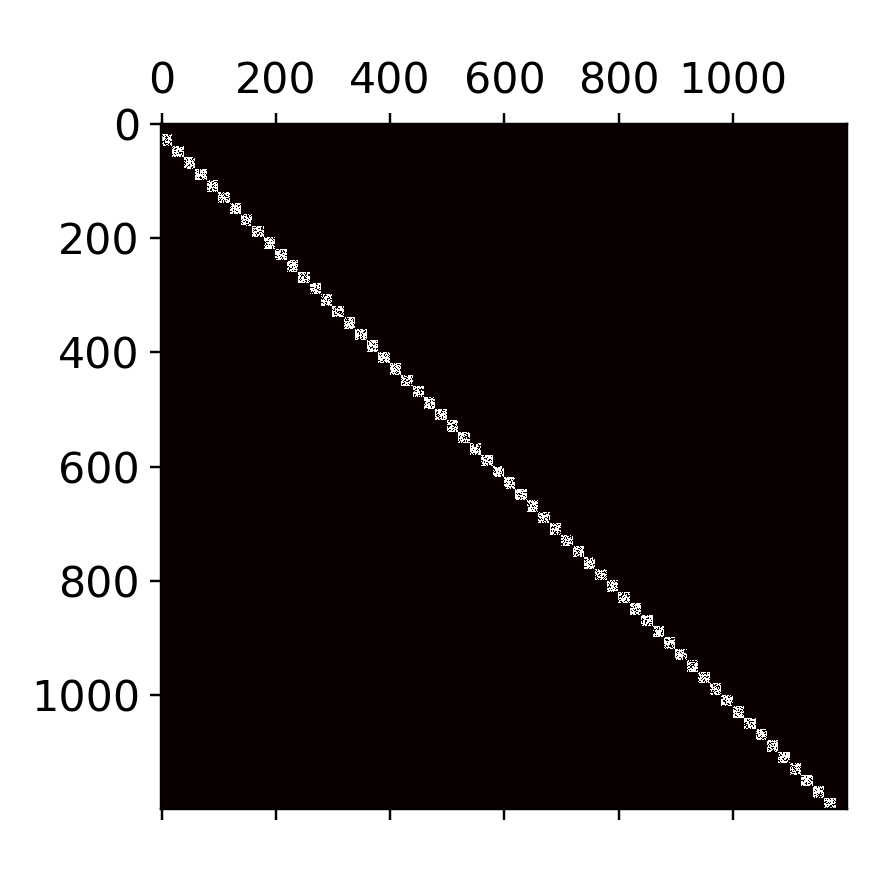

<IPython.core.display.Javascript object>


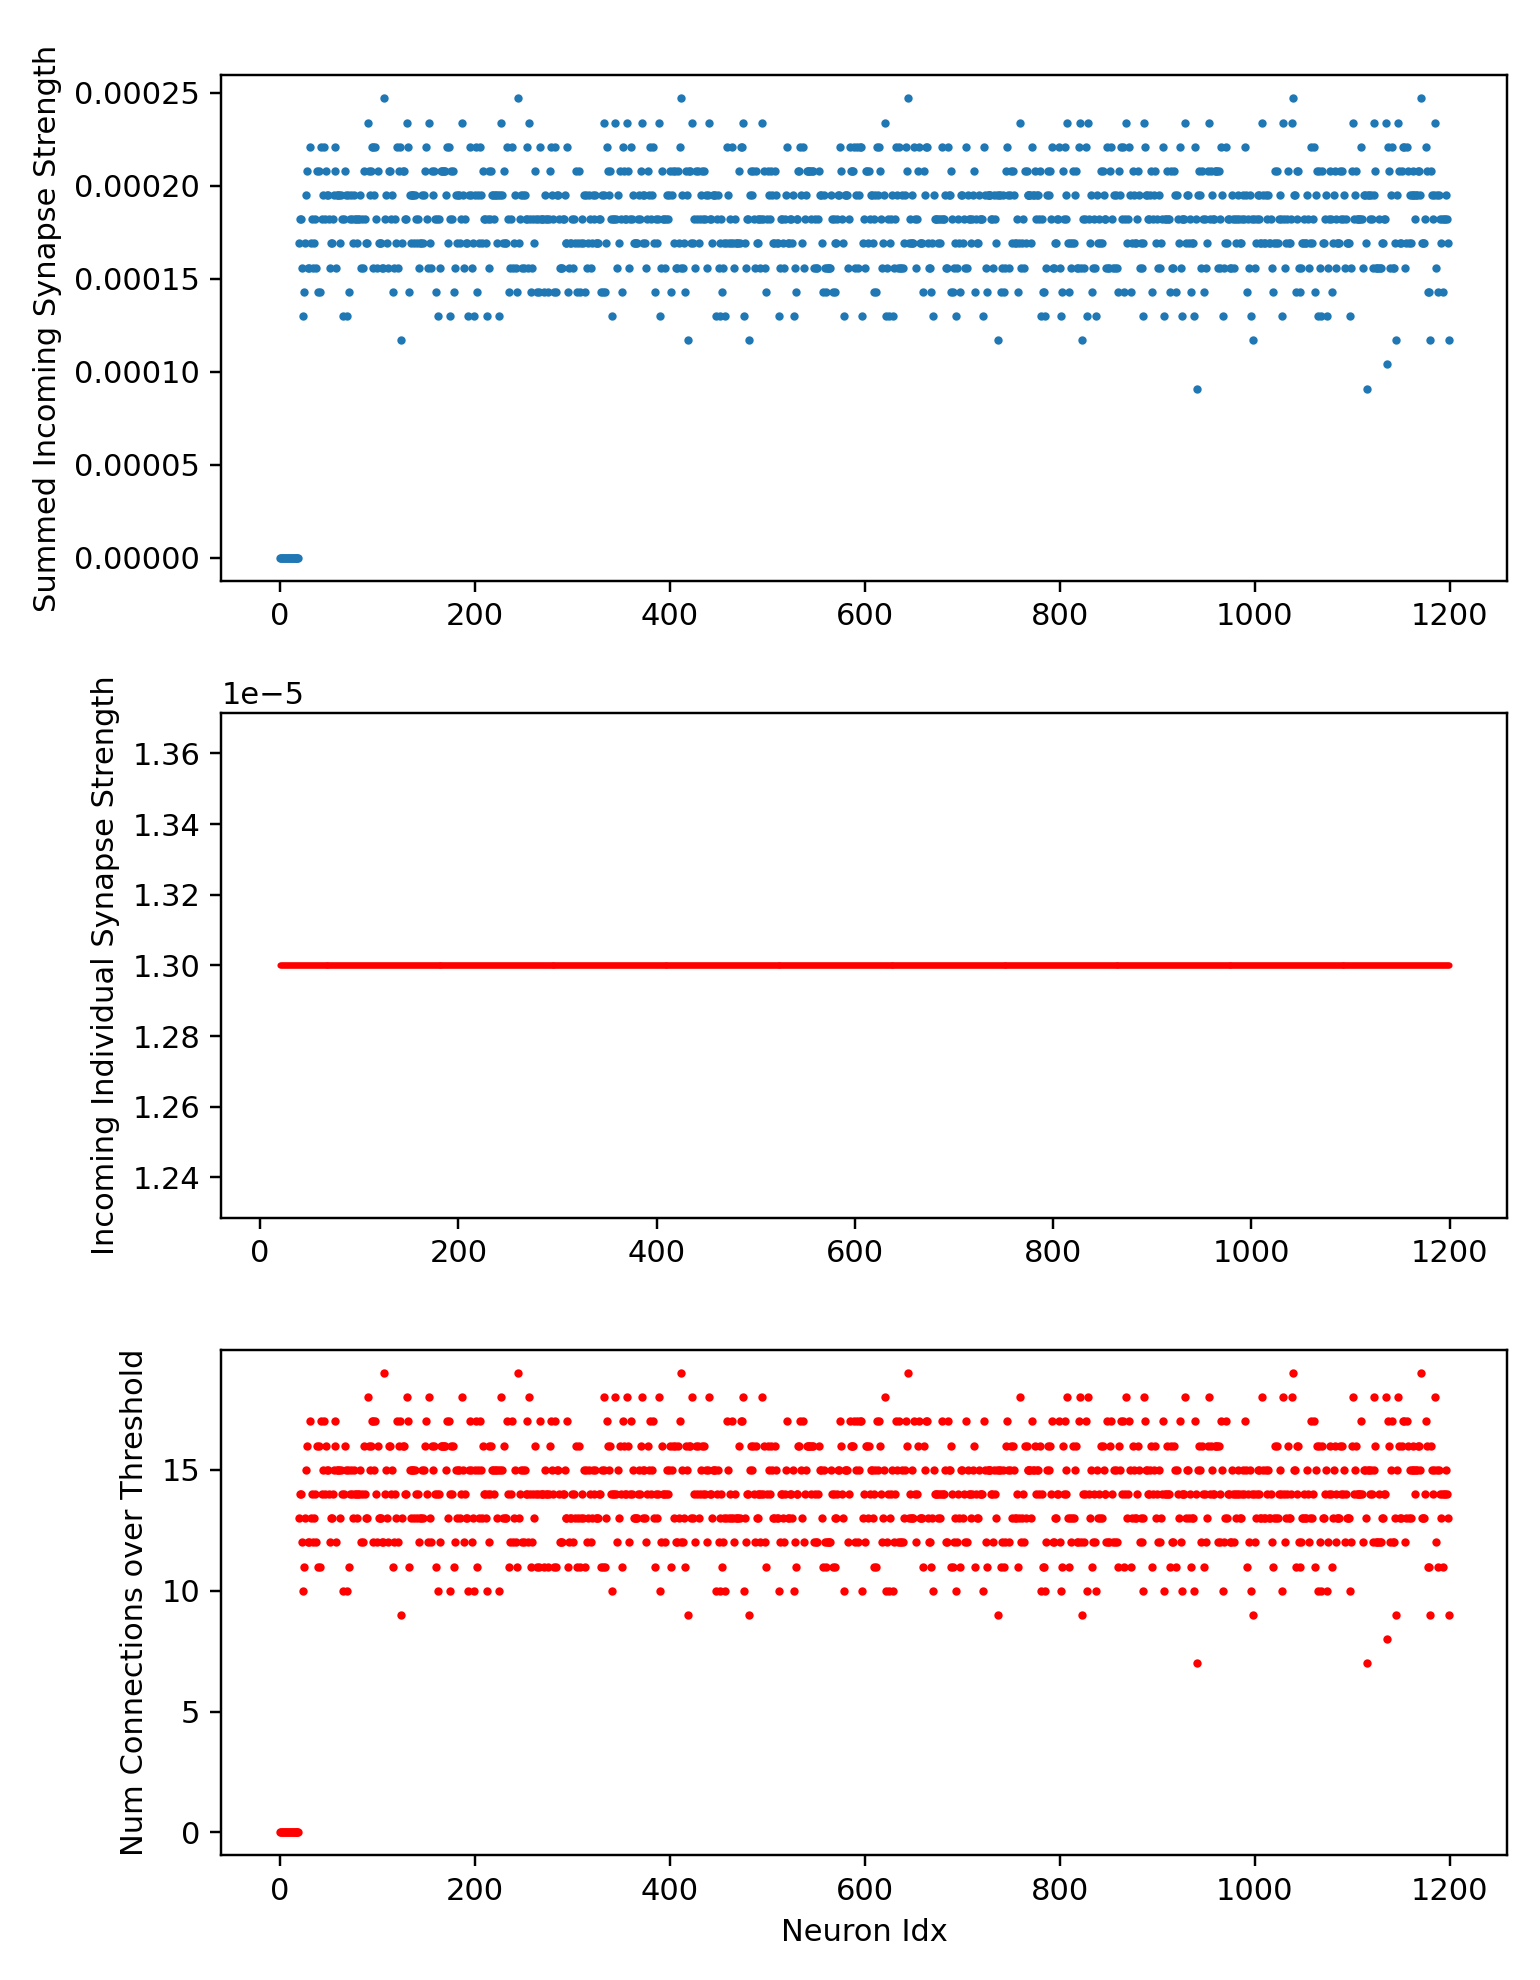

average summed incoming weight per cell: 0.00017837083333333326 +/- 3.448775119718431e-05
average incoming connections per cell: 13.720833333333333 +/- 2.652903938244948


In [32]:
plot_w_r(w_r_e_initial, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


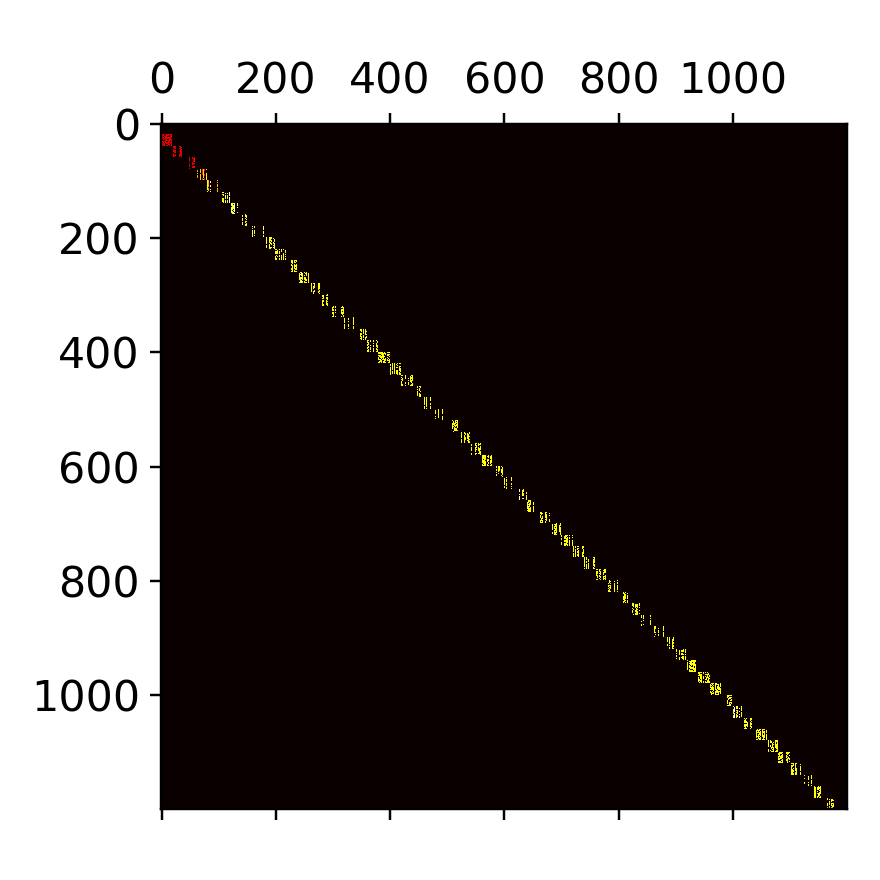

<IPython.core.display.Javascript object>


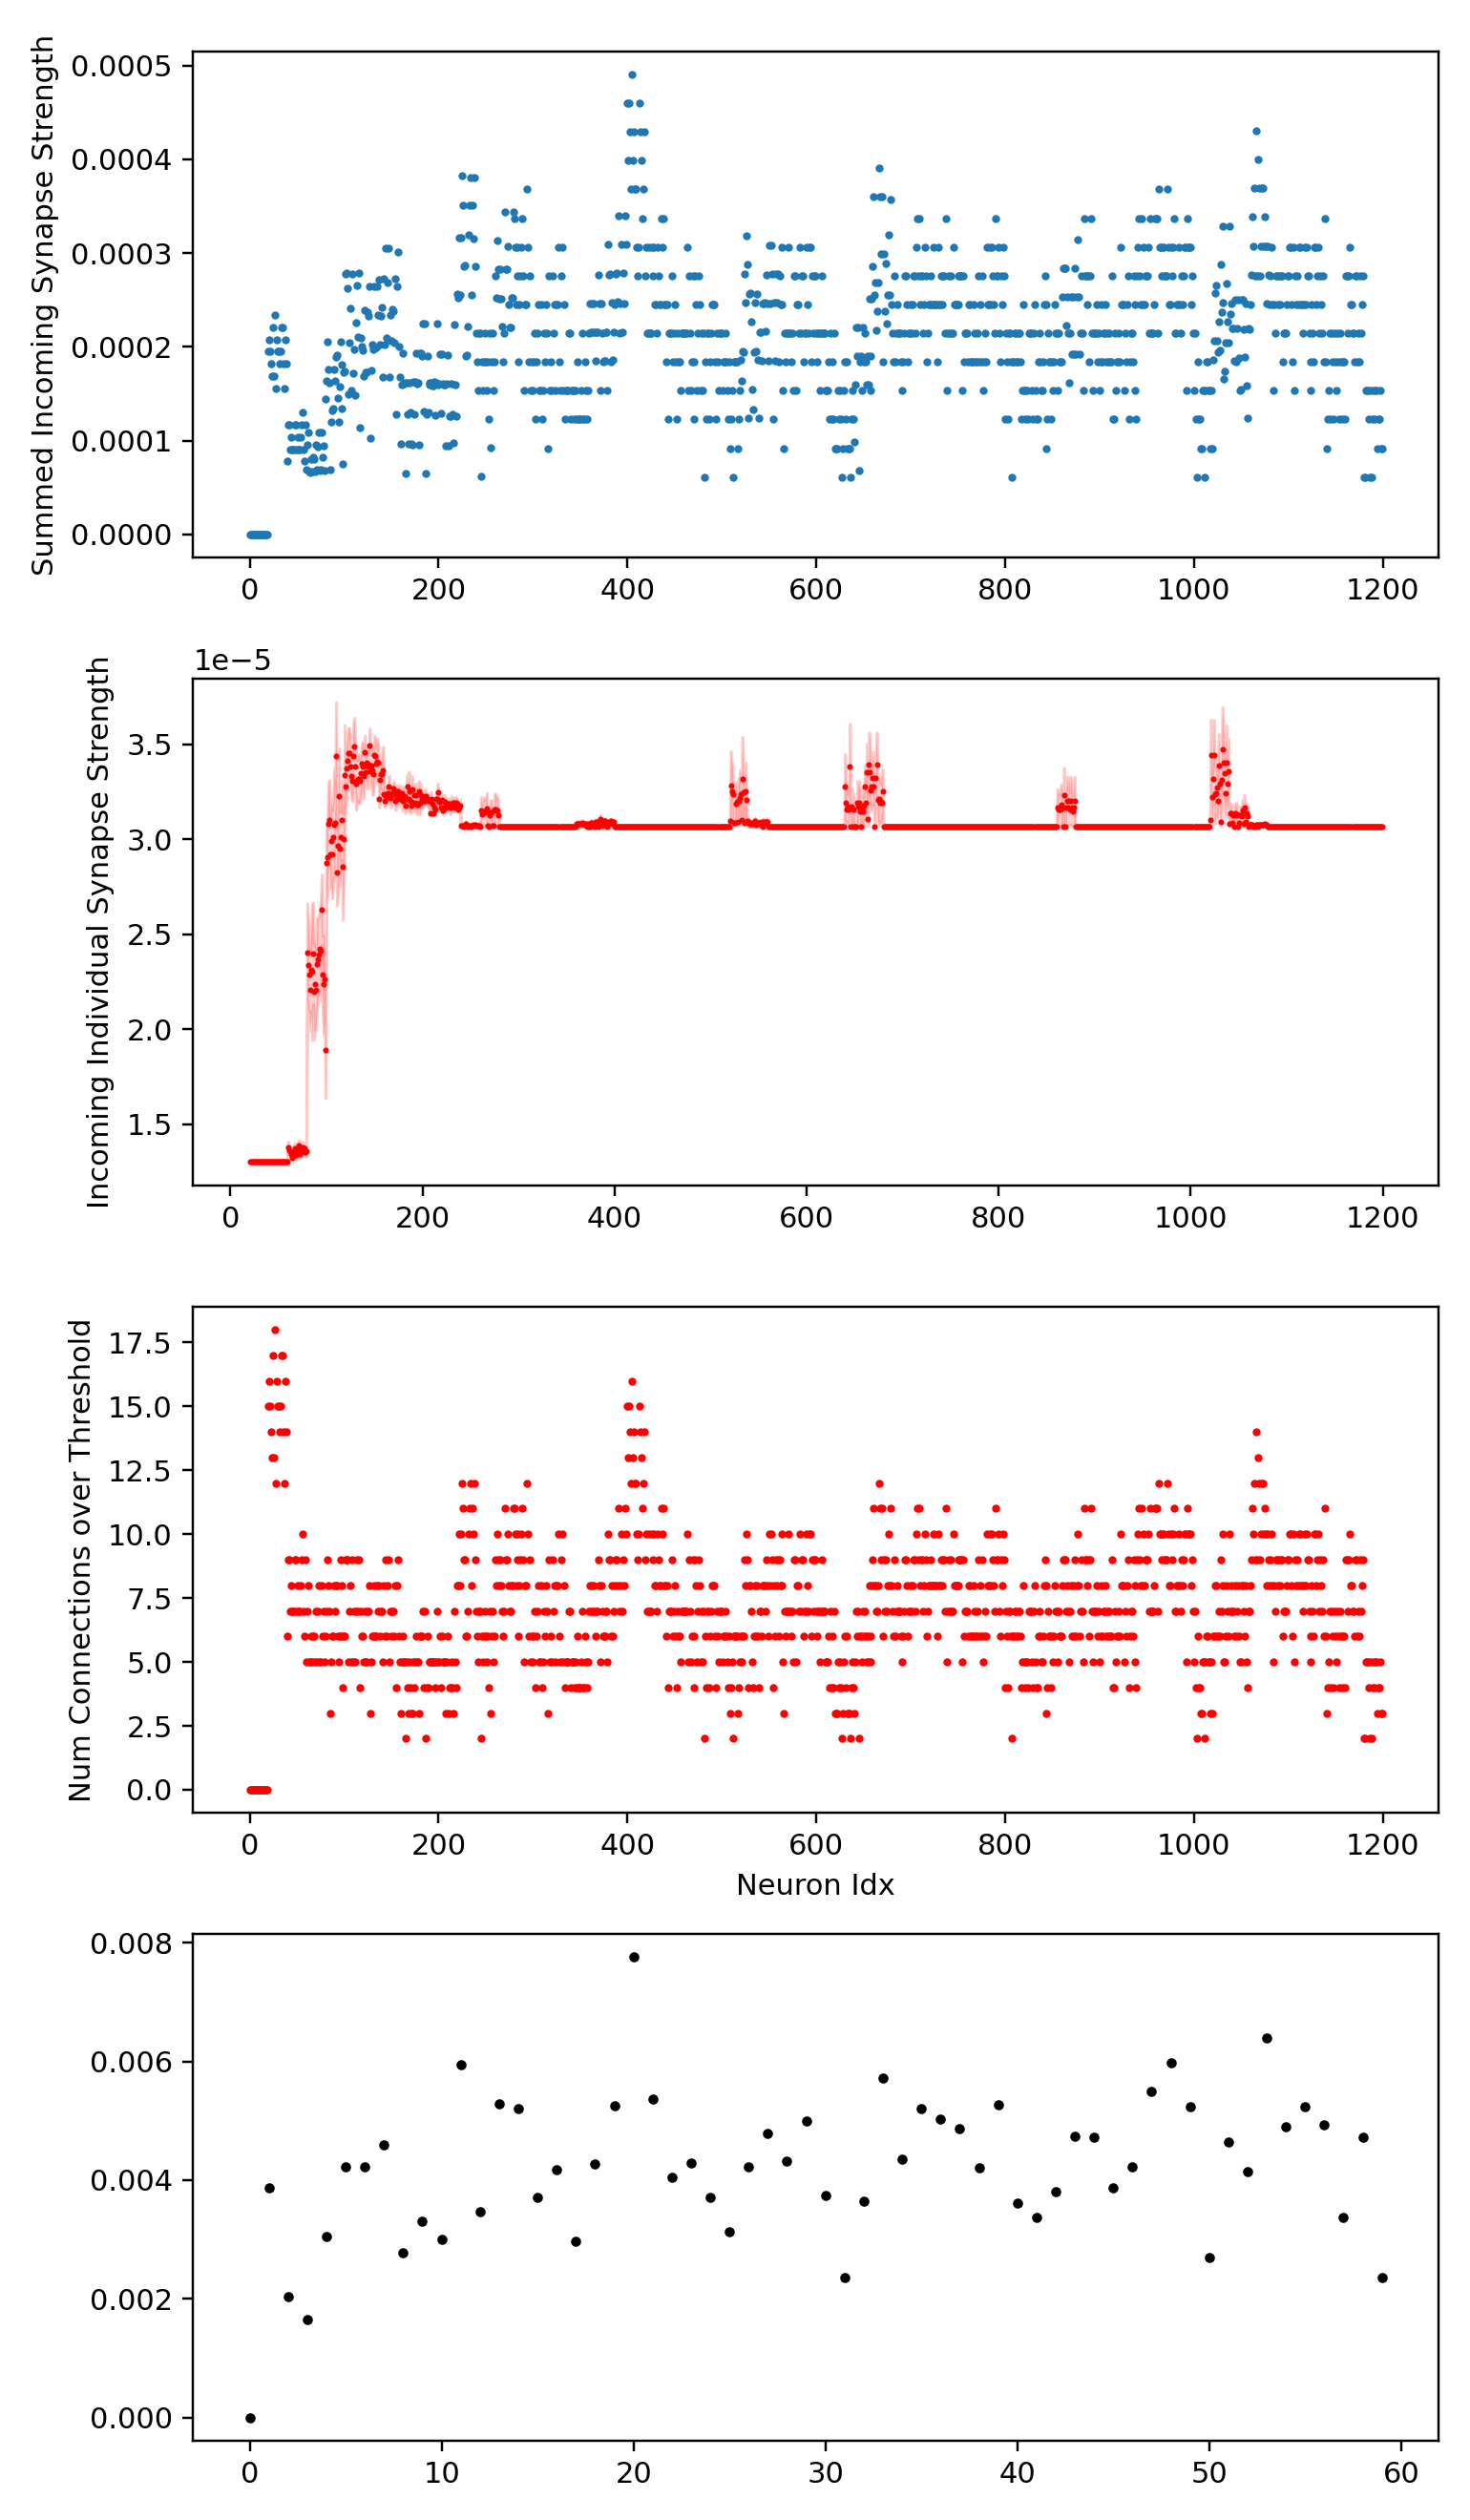

average summed incoming weight per cell: 0.00021042069252933323 +/- 7.480467523089612e-05
average incoming connections per cell: 7.0925 +/- 2.5368504915872885


In [45]:
plot_w_r(w_r_e_final, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


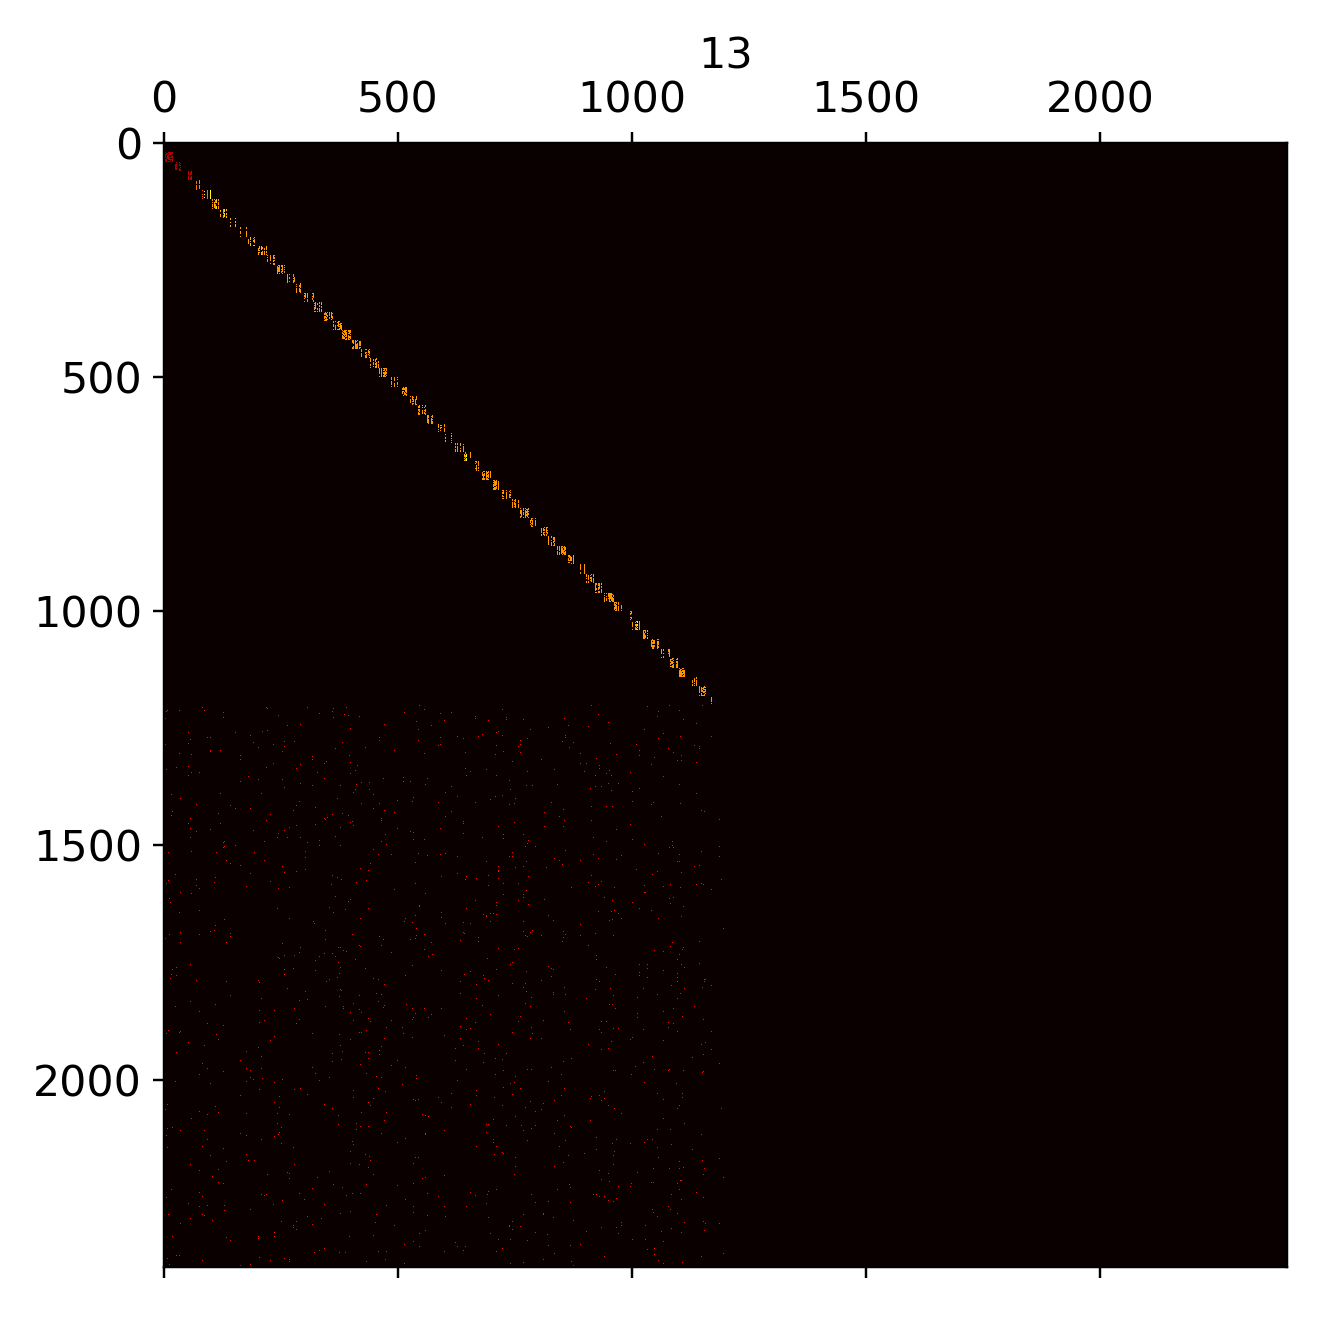

In [34]:
w_r_e_initial, w_r_e_final = animate('./robustness/noise_ff_0.2_pf_0.7_pr_0.0_eir_2.0_ier_0.3_dropout_sweep_2021-03-31--00:27--46:6021', 10, 0.26 * 0.004 * 1 / 20,
                                 cmap='hot', kind='w_r_e', cut=14)

<IPython.core.display.Javascript object>


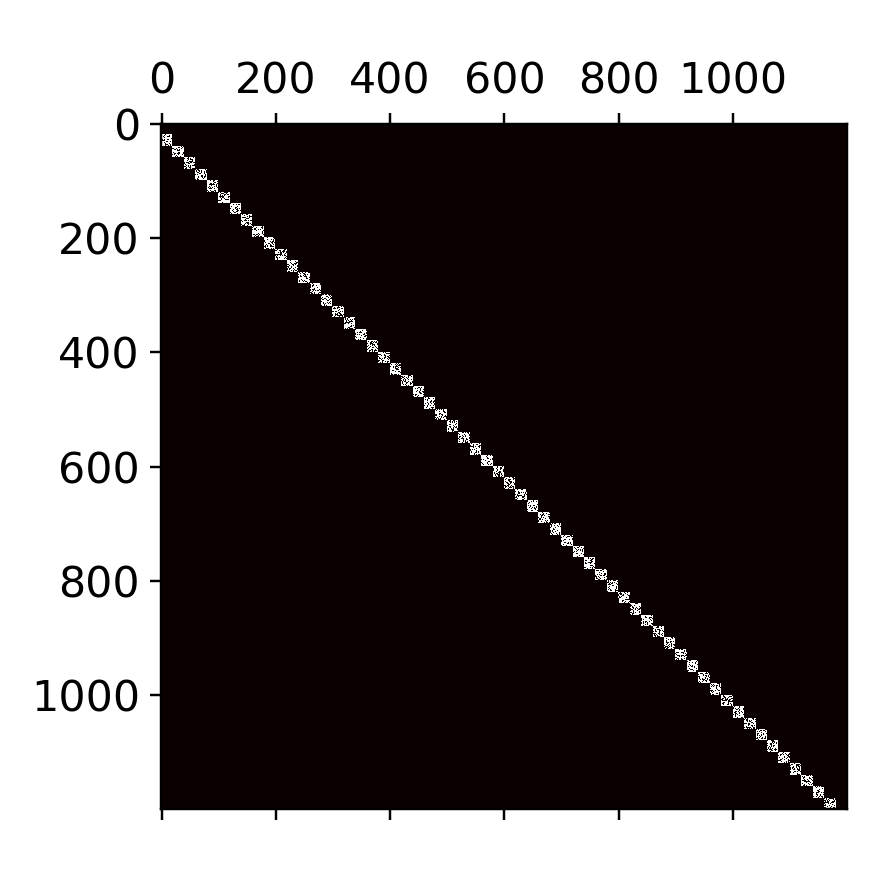

<IPython.core.display.Javascript object>


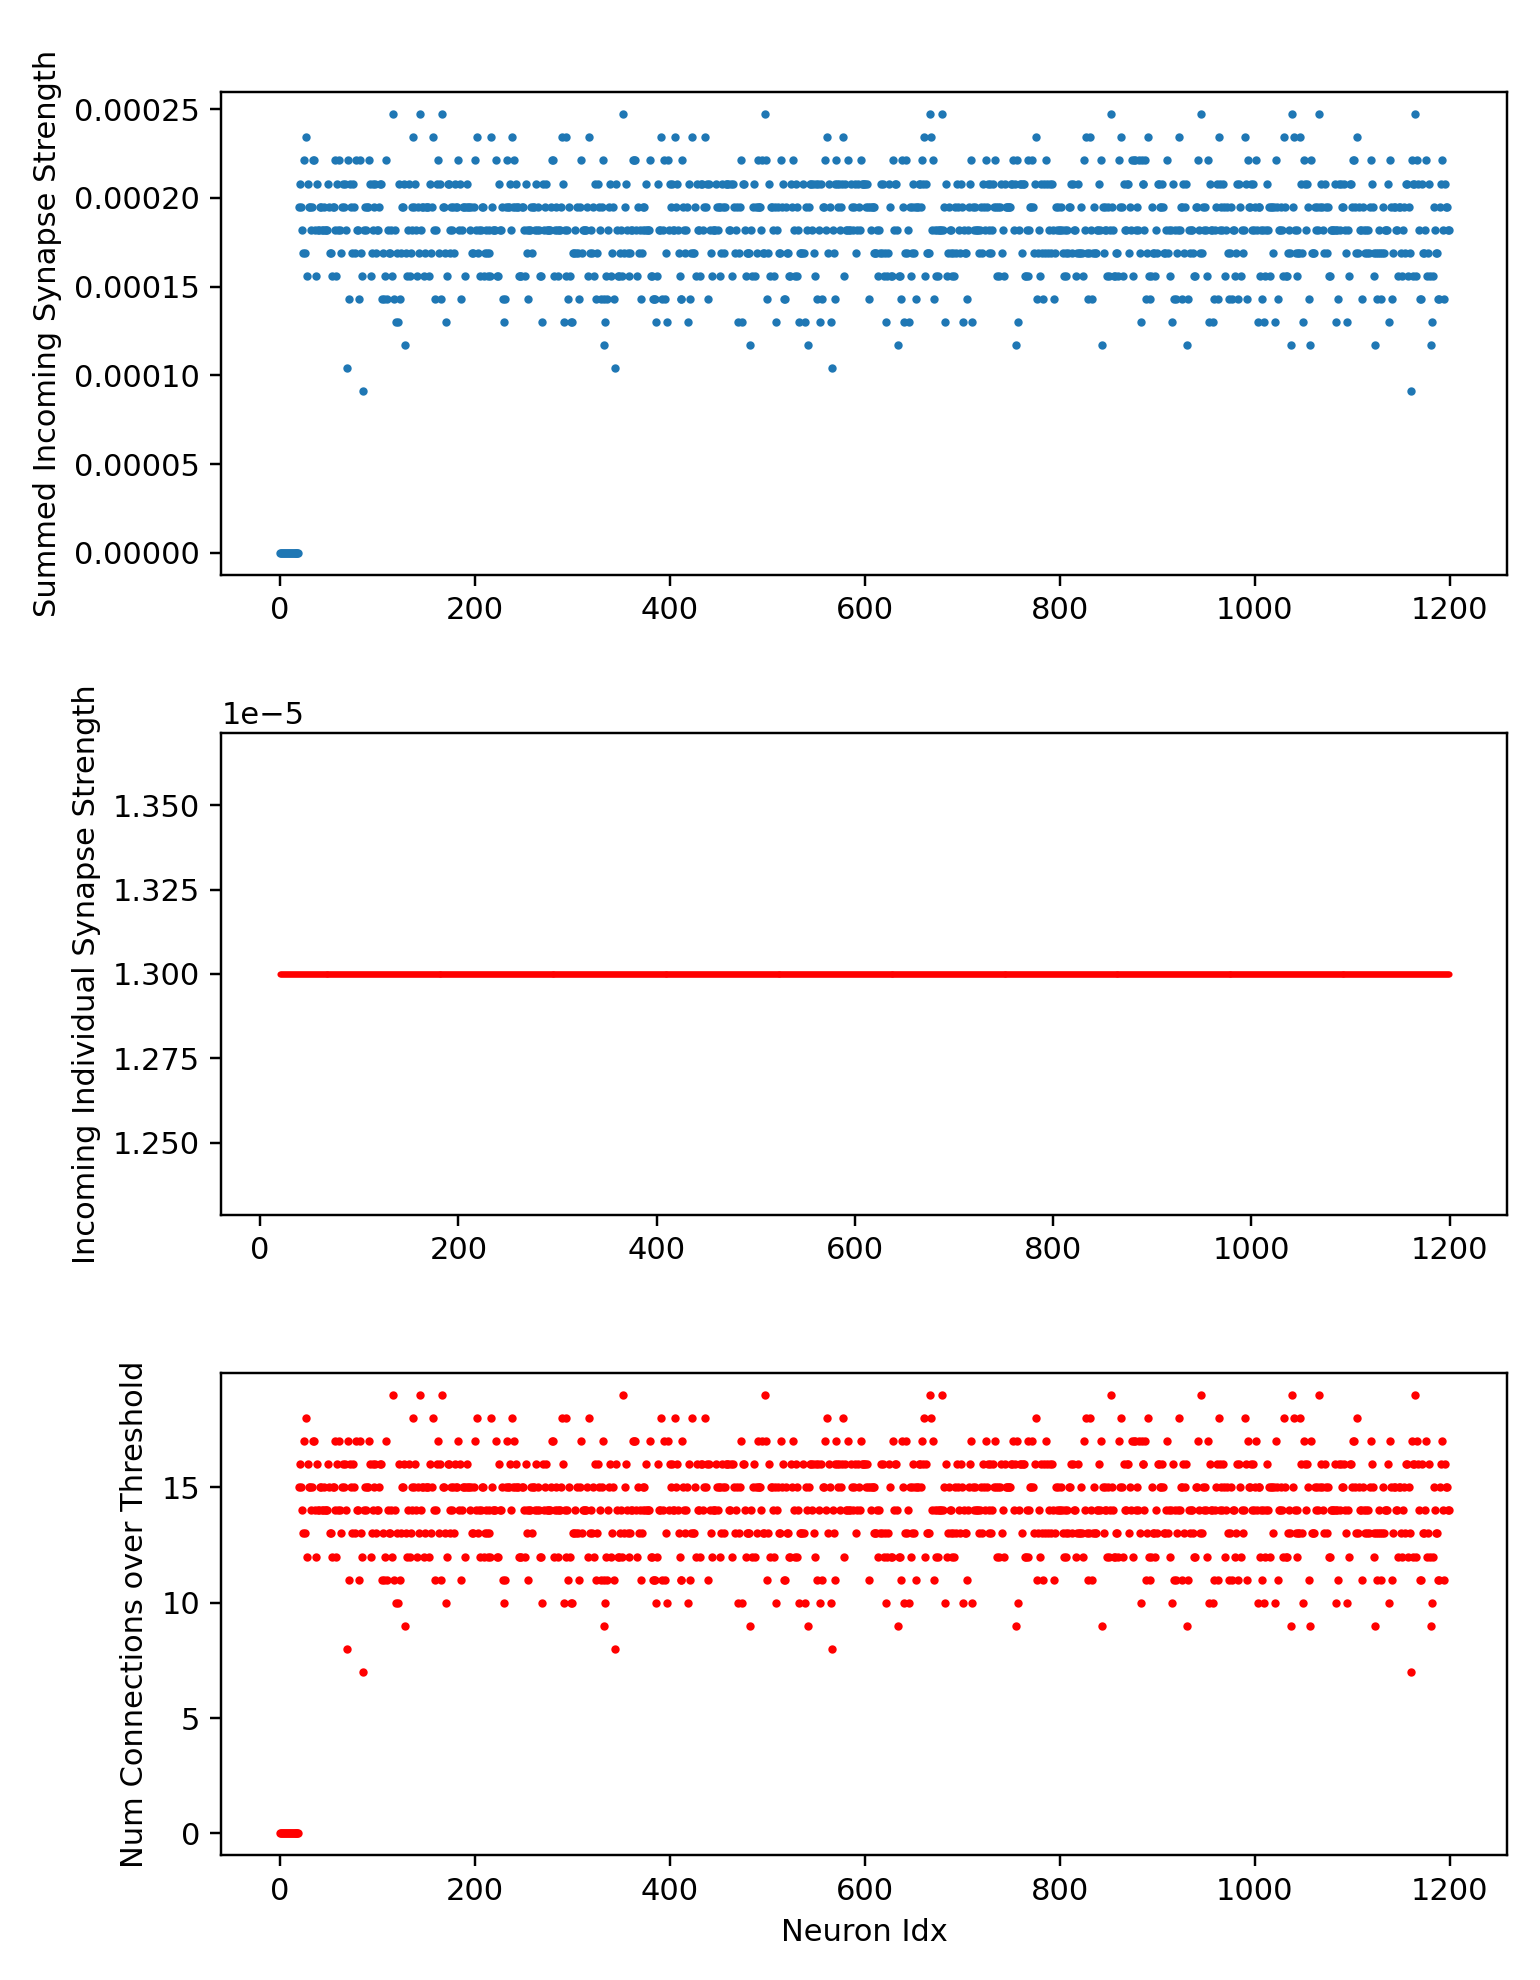

average summed incoming weight per cell: 0.00017981166666666663 +/- 3.4854380842139314e-05
average incoming connections per cell: 13.831666666666667 +/- 2.681106218626102


In [35]:
plot_w_r(w_r_e_initial, row_max=1200, col_max=1200)

<IPython.core.display.Javascript object>


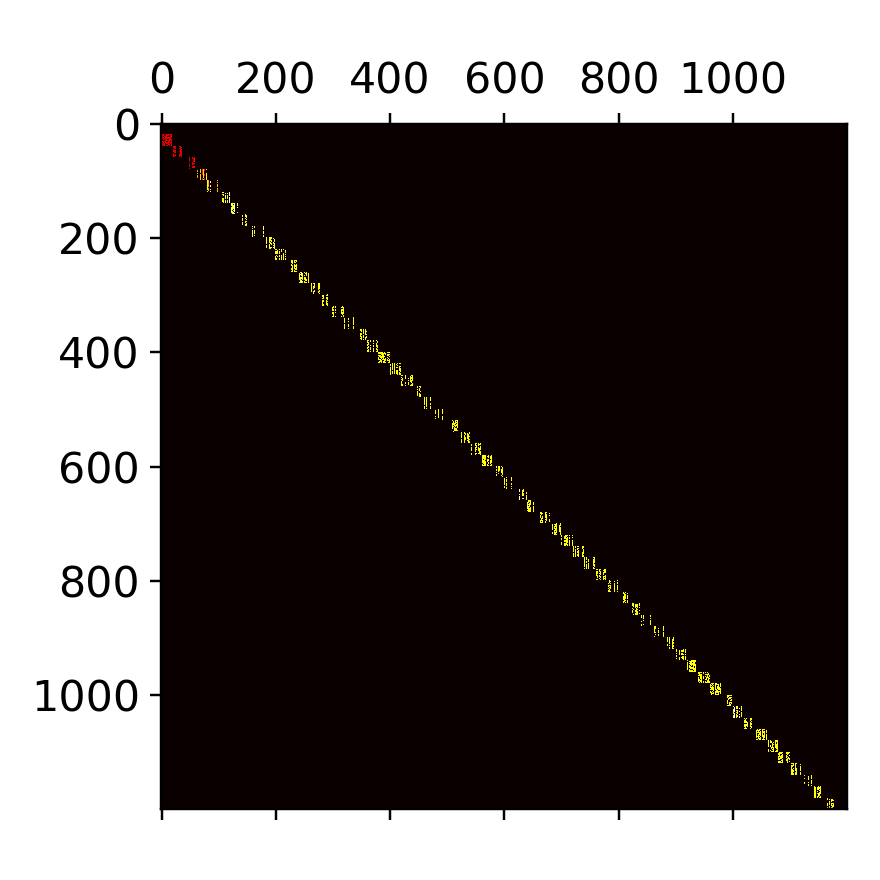

<IPython.core.display.Javascript object>


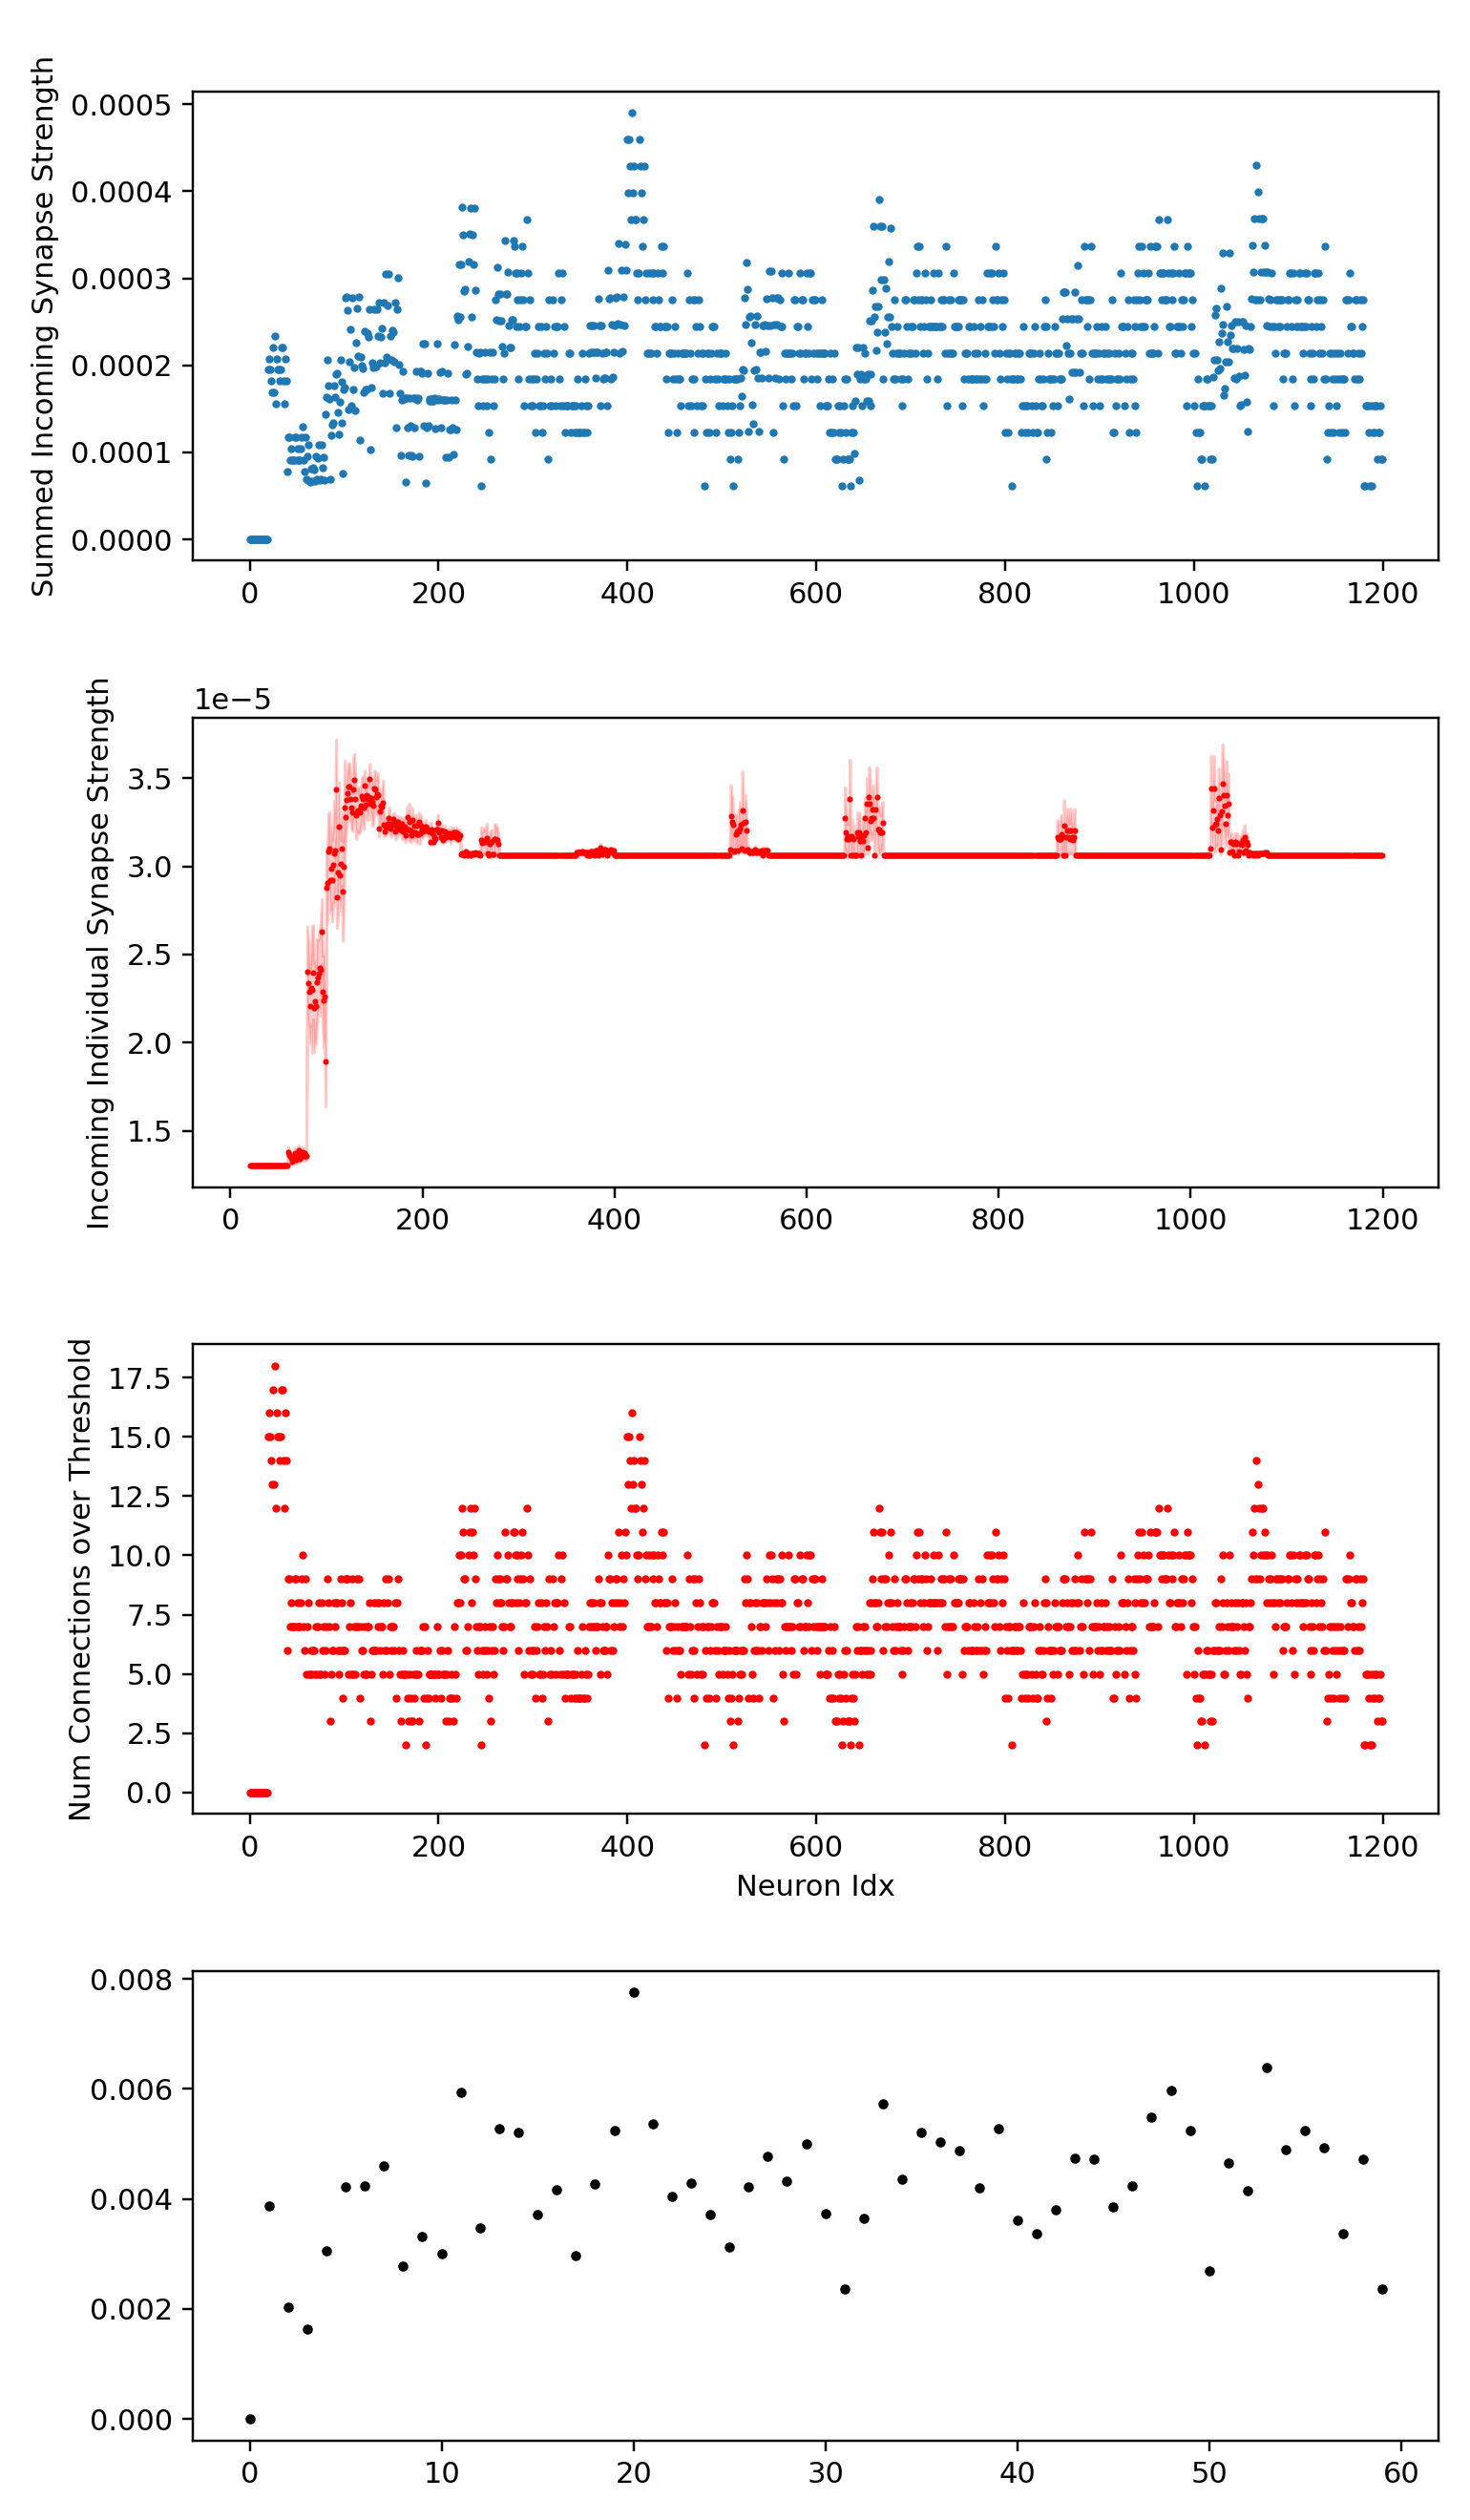

average summed incoming weight per cell: 0.00021042069252933323 +/- 7.480467523089612e-05
average incoming connections per cell: 7.0925 +/- 2.5368504915872885


In [46]:
plot_w_r(w_r_e_final, row_max=1200, col_max=1200)